In [1]:
import scanpy as scp
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import scipy as sp
import pandas as pd

import sys
sys.path.append('../../')
from scCustomFunctions import *
from parameters import *

from sklearn import preprocessing

import os

#import pydpc

import warnings
warnings.filterwarnings('ignore')

In [2]:
a = scp.read("data/qc.h5ad")

# Clustering

We cluster the different stages using a the following algorithms:

1. Louvain


Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


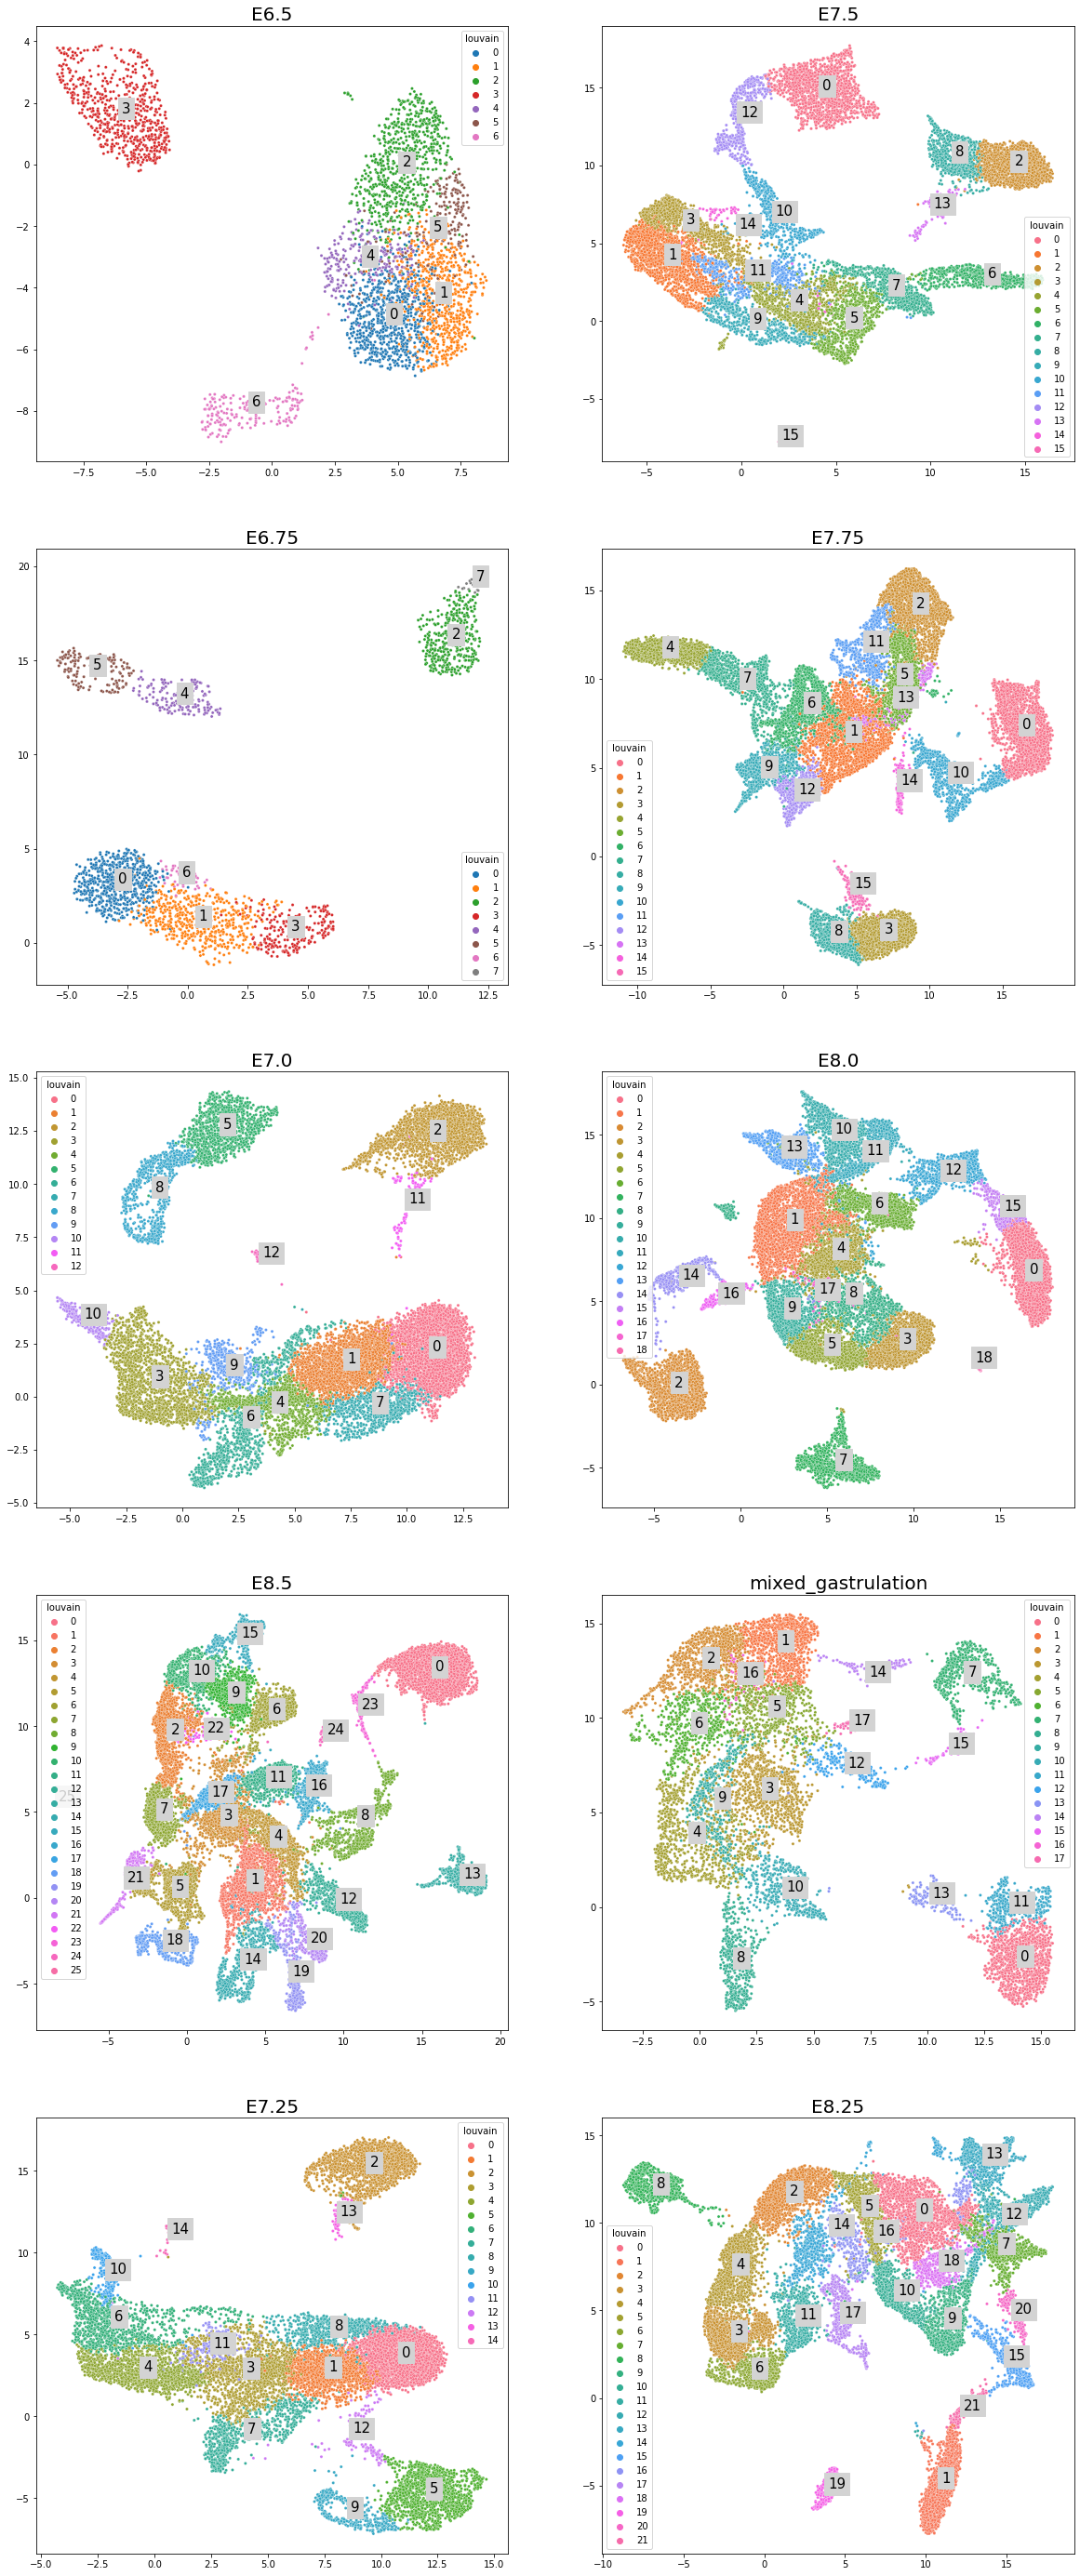

In [6]:
fig1,ax1 = plt.subplots(5,2,figsize=[20,50])
#fig2,ax2 = plt.subplots(5,2,figsize=[20,50])
#fig3,ax3 = plt.subplots(5,2,figsize=[20,50])

a.obs["louvain"] = 0
for j,stage in enumerate(a.obs["stage"].unique()[:]):
    
    posx = j//2
    posy = j%2
    
    b = a[a.obs["stage"]==stage]
    b.obs["sample"]=b.obs["sample"].astype(str)
    
    #Load data from batch correction    
    scp.pp.neighbors(b,knn=N_NEIGBOURS,n_pcs=N_PCS,use_rep="X_pca_harmony_stages")
    
    #Clustering algorithms
    
    ## Louvain
    scp.tl.louvain(b,resolution=LOUVAIN_RESOLUTION)
    
    a.obs.loc[b.obs.index.values,"louvain"] = b.obs.loc[:,"louvain"]
    
    sb.scatterplot(b.obsm["X_umap_harmony_stages"][:,0],b.obsm["X_umap_harmony_stages"][:,1],hue=b.obs["louvain"],s=10,ax=ax1[posx,posy])
    ax1[posx,posy].set_title(stage,fontsize=20)
    for k in b.obs["louvain"].unique():
        pos = b[b.obs["louvain"]==k,:].obsm["X_umap_harmony_stages"]
        pos = np.nan_to_num(pos)
        pos = pos.mean(axis=0)
        ax1[posx,posy].text(pos[0],pos[1],k,fontsize=15,backgroundcolor="lightgrey")
    
    ##DPC
    #X = b.obsm["X_umap"].copy(order='C').astype("float64") #Something to make sure that we get the appropiate format so pydpc accepts it
    #X_proc = preprocessing.StandardScaler().fit_transform(X)
    #cluster = pydpc.Cluster(X_proc,autoplot=False);
    #cluster.assign(DPC_CUT_PARAMETERS[0],DPC_CUT_PARAMETERS[1])
    #b.obs["DPC"] = cluster.membership.astype(str)
    #data.loc[b.obs.index.astype(int),"DPC"] = b.obs["DPC"].values  
    
    #sb.scatterplot(b.obsm["X_umap"][:,0],b.obsm["X_umap"][:,1],hue=b.obs["DPC"],s=10,ax=ax3[posx,posy])
    #ax3[posx,posy].set_title(stage,fontsize=20)
    #for k in b.obs["DPC"].unique():
    #    pos = b[b.obs["DPC"]==k,:].obsm["X_umap"]
    #    pos = np.nan_to_num(pos)
    #    pos = pos.mean(axis=0)
    #    ax3[posx,posy].text(pos[0],pos[1],k,fontsize=10,backgroundcolor="grey")
        
    #c = np.greater(cluster.density,DPC_CUT_PARAMETERS[0]) * np.greater(cluster.delta,DPC_CUT_PARAMETERS[1])
    #sb.scatterplot(cluster.density,cluster.delta,hue=c,s=10,ax=ax2[posx,posy])
    #ax2[posx,posy].set_title(stage,fontsize=20)
        
fig1.savefig("Plots/3_Louvain_clusters.png",bbox_inches="tight",transparent=True)
#fig2.savefig("Plots/5_Clustering/DPC_scatterplot.png",bbox_inches="tight",transparent=True)
#fig3.savefig("Plots/5_Clustering/DCP_cluster.png",bbox_inches="tight",transparent=True)

#plt.close(fig1); plt.close(fig2); plt.close(fig3)

In [4]:
a.write("data/qc.h5ad")

# Create files for manual annotation

For the manual annotation we use the following information:

1. A list of Differentially Expressed genes of each cluster vs. the rest.
2. Plots of gene expression over the UMAP for characteristic genes (to be found in parameters.py).

Trying to set attribute `.obs` of view, copying.
... storing 'louvain' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'louvain' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'louvain' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'louvain' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'louvain' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'louvain' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'louvain' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'louvain' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'louvain' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'louvain' as categorical


['Adh1a2', 'Bmp8', 'Msgn']  don't express


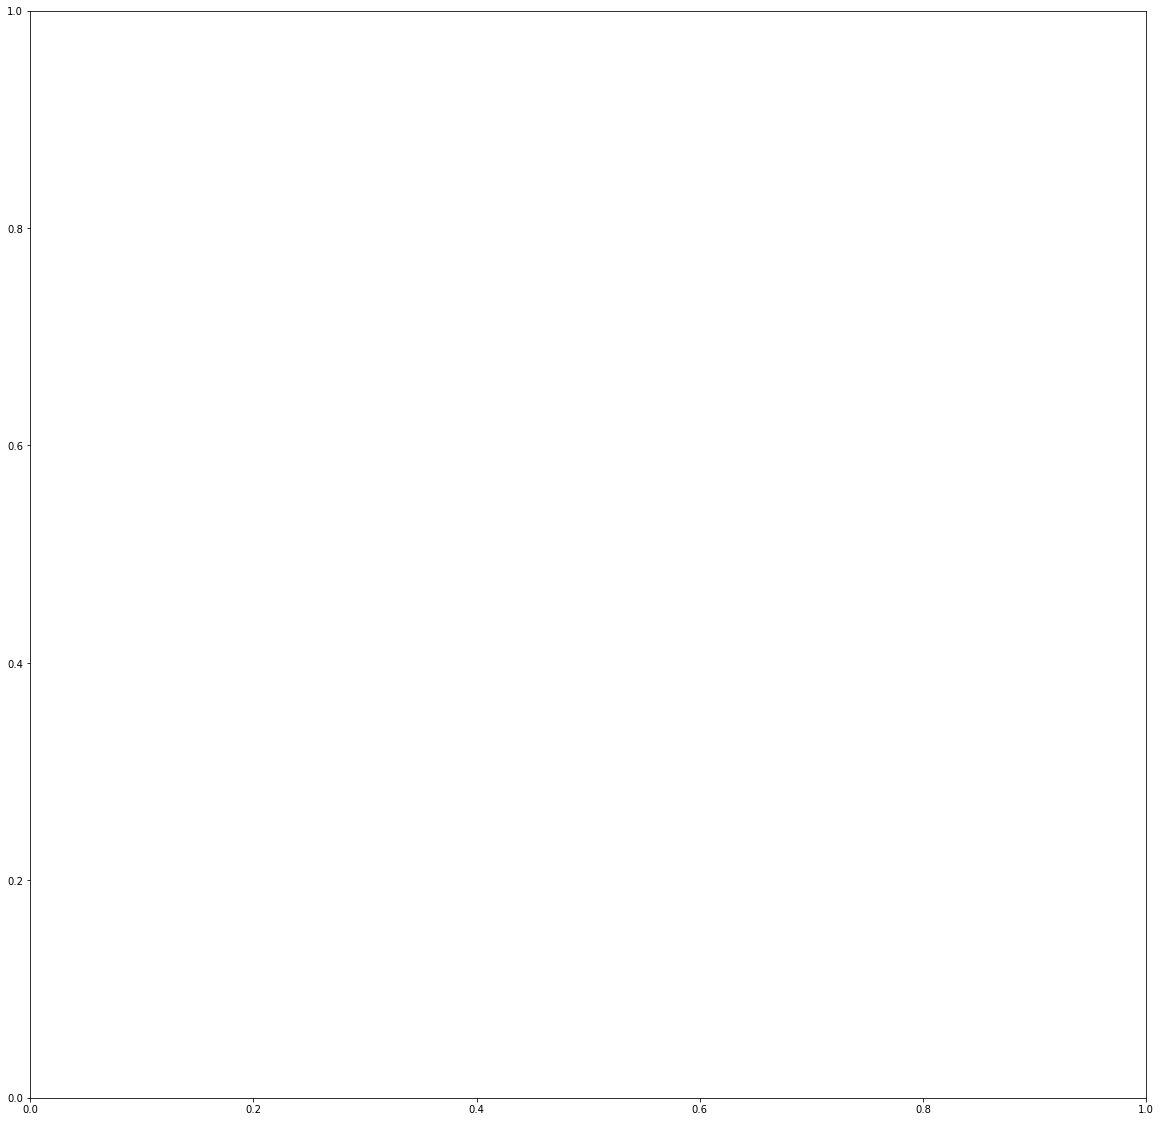

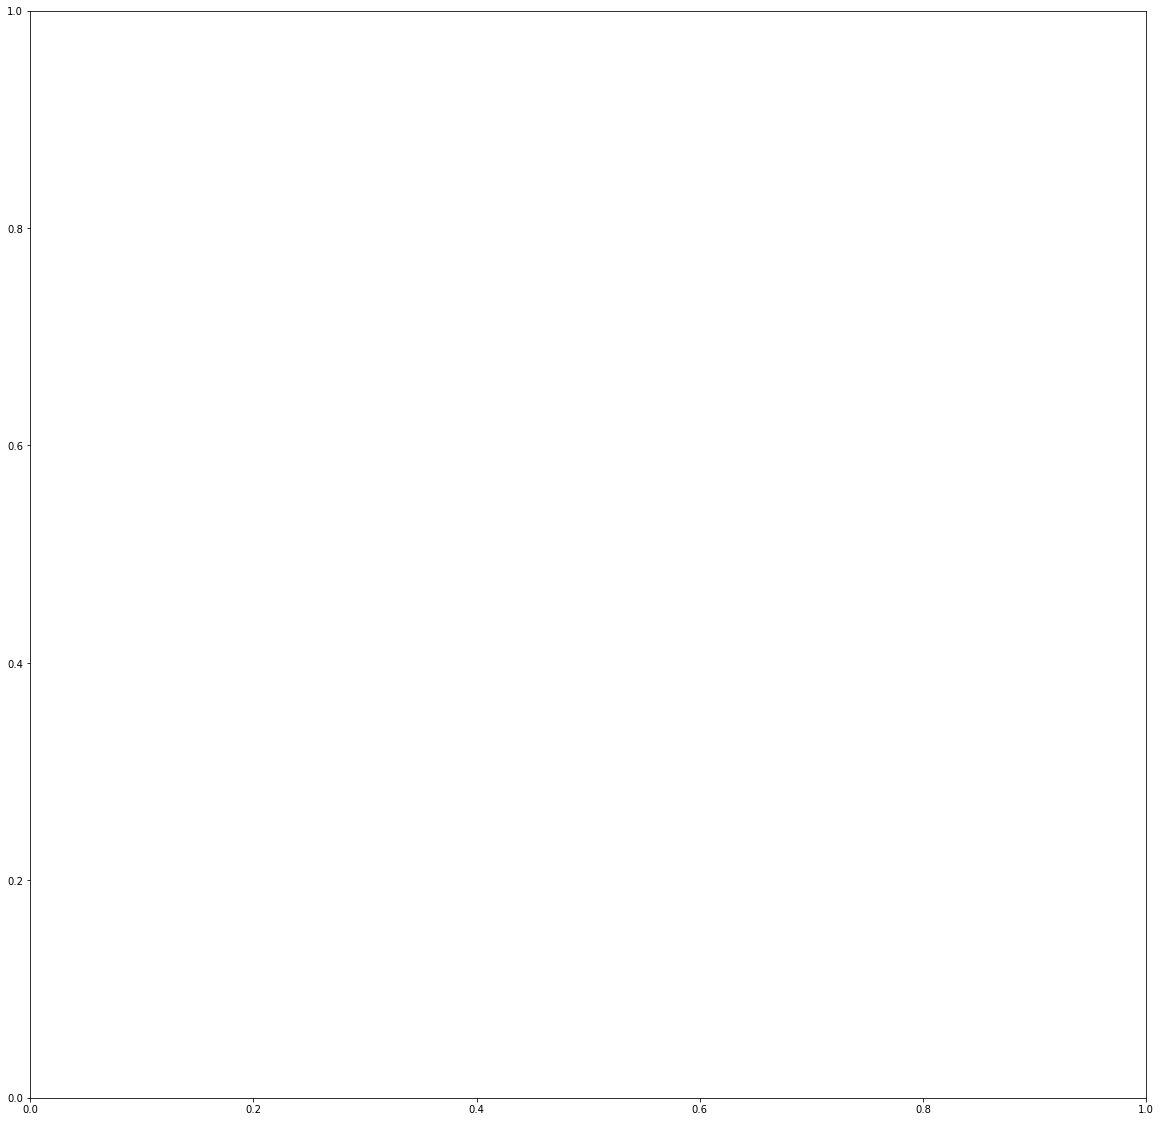

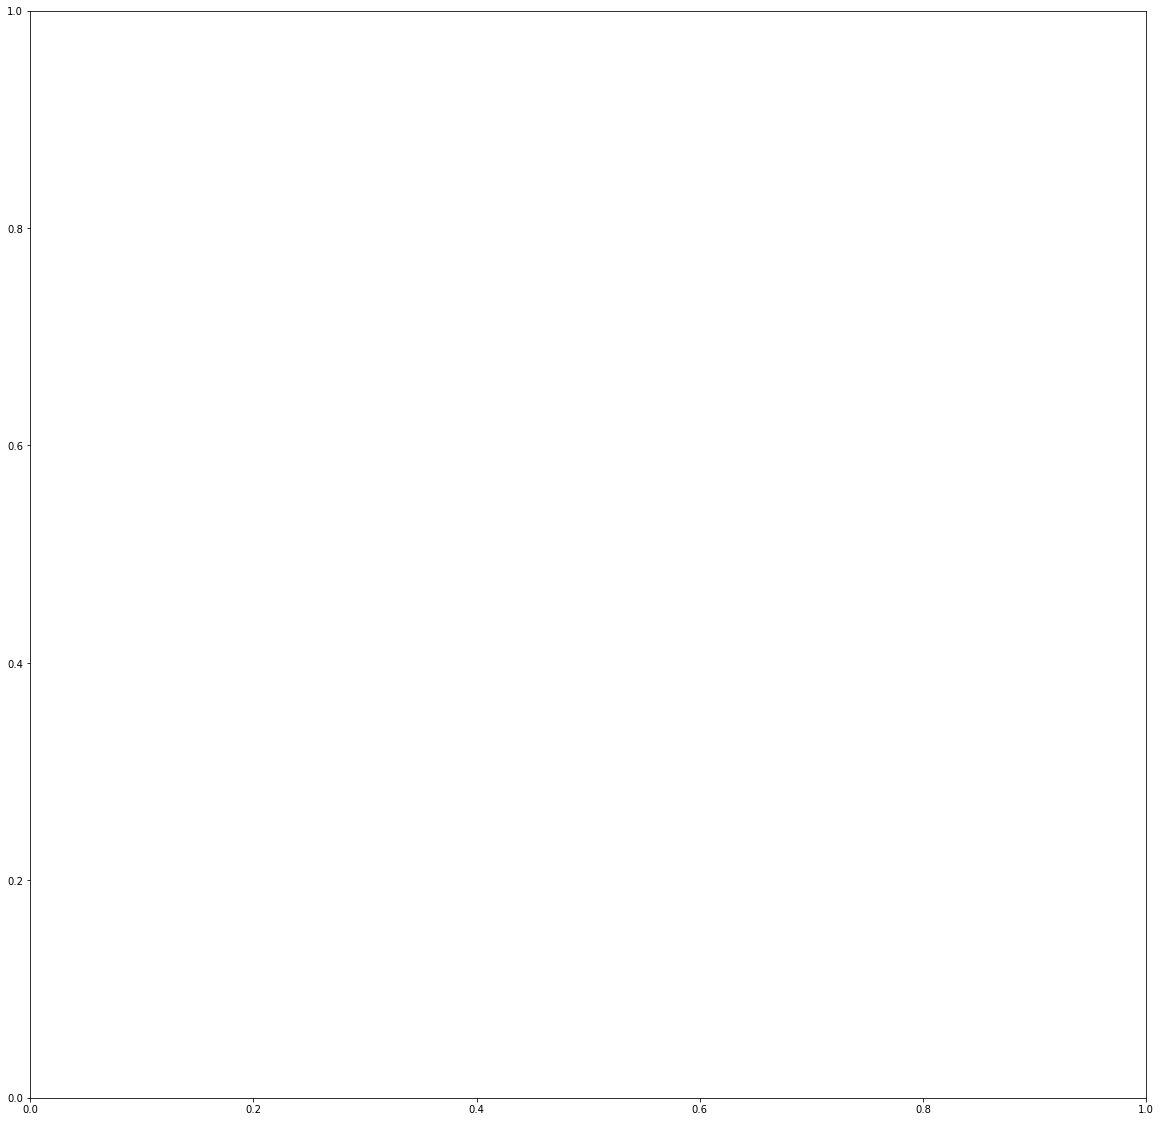

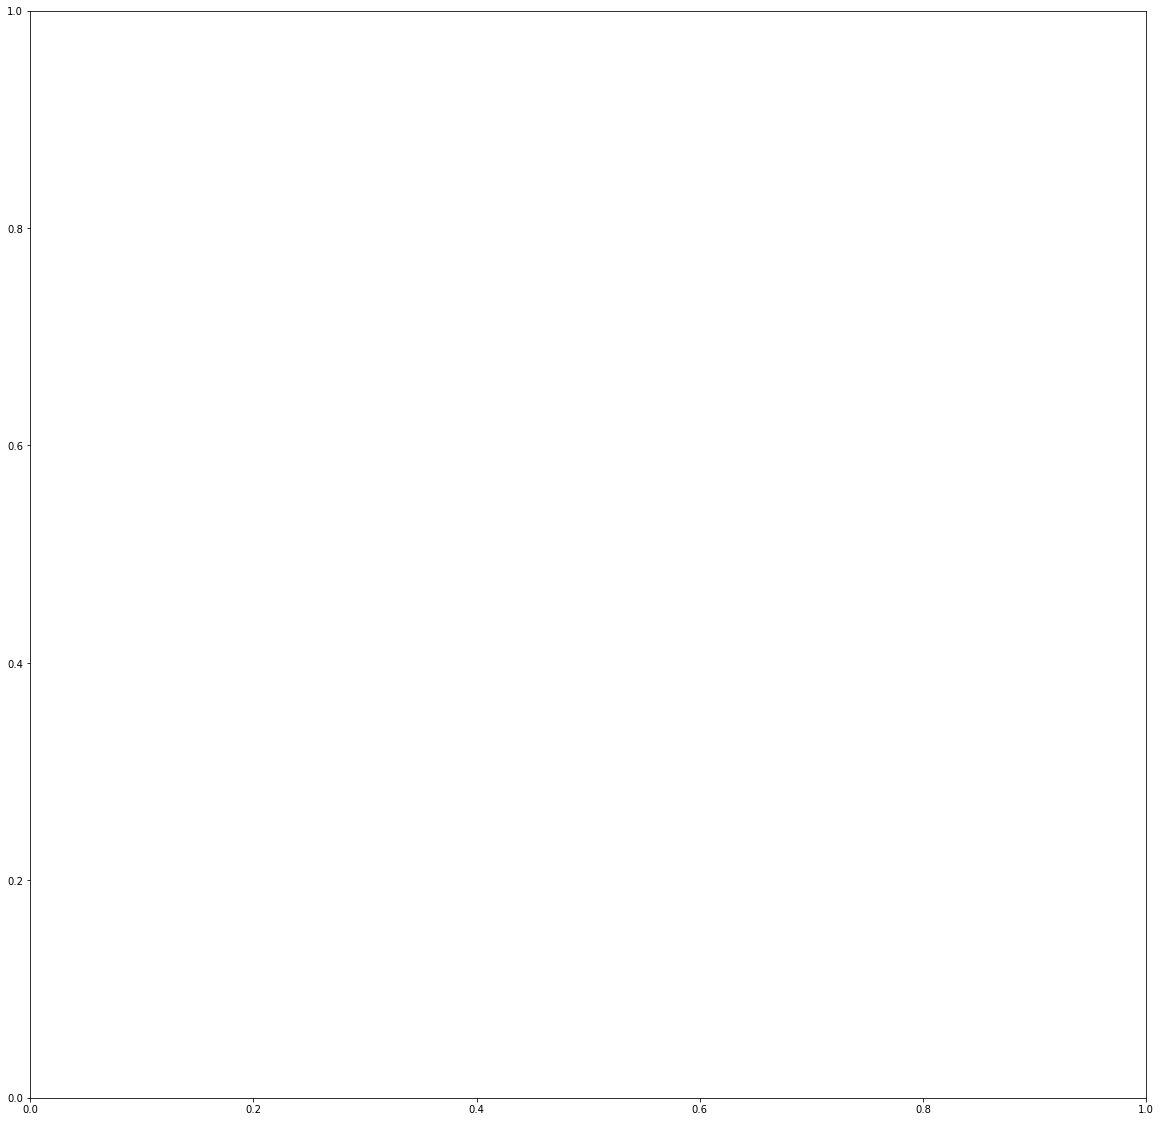

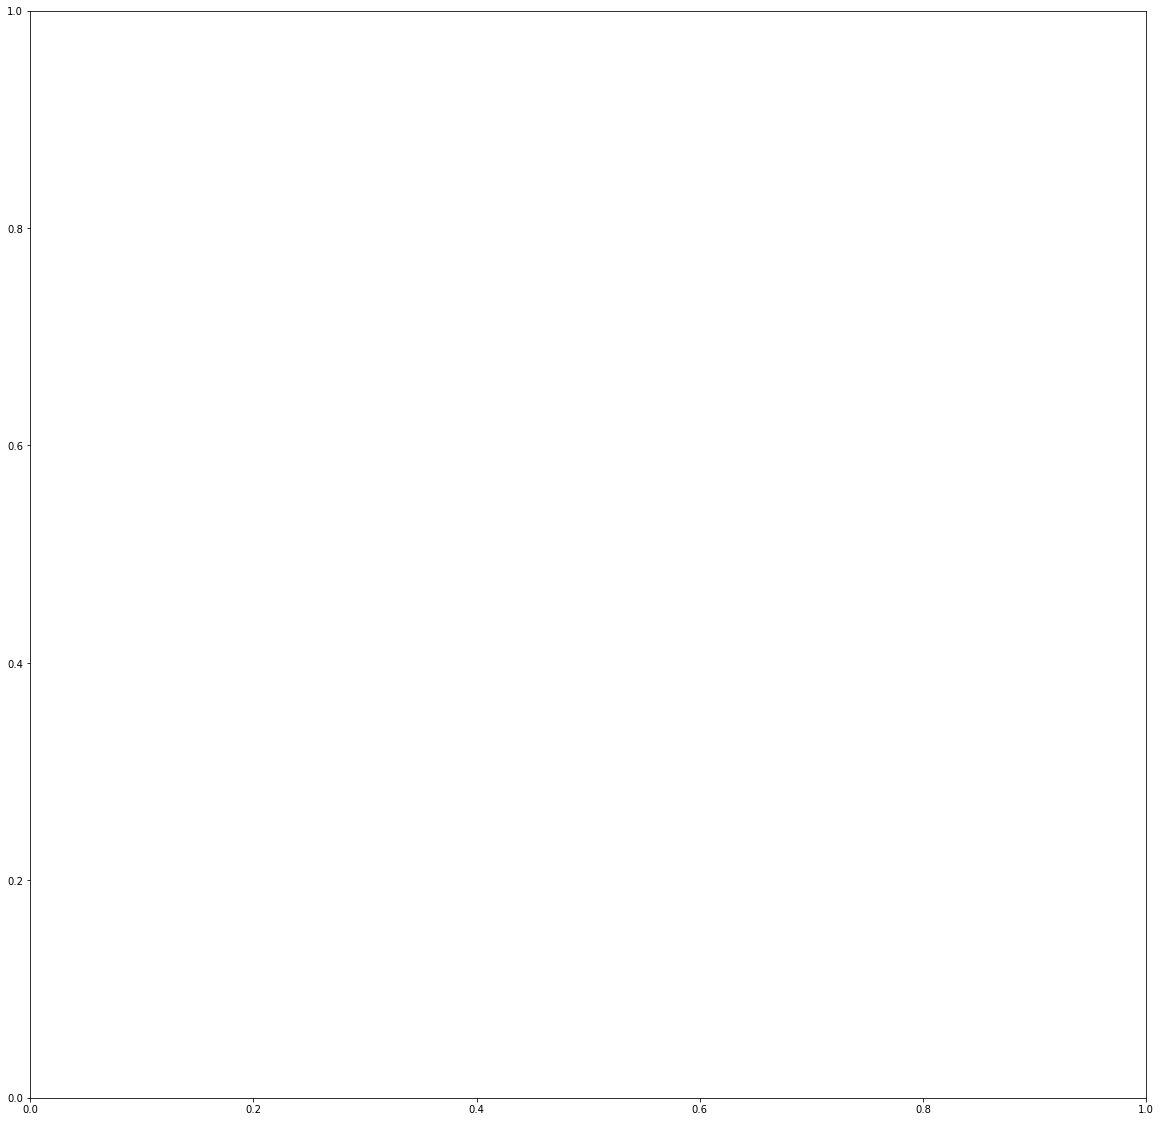

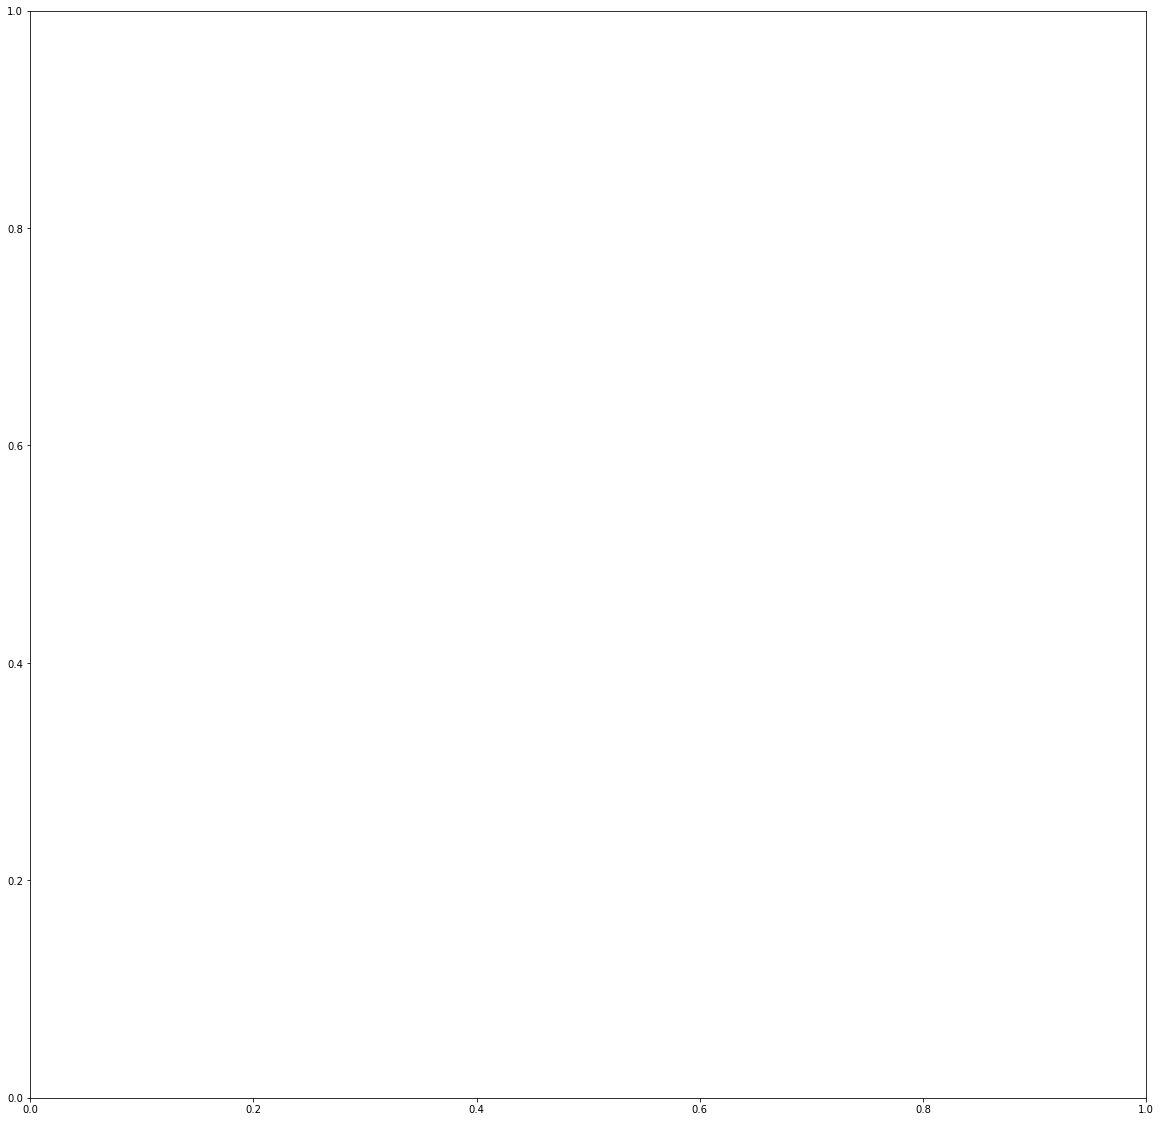

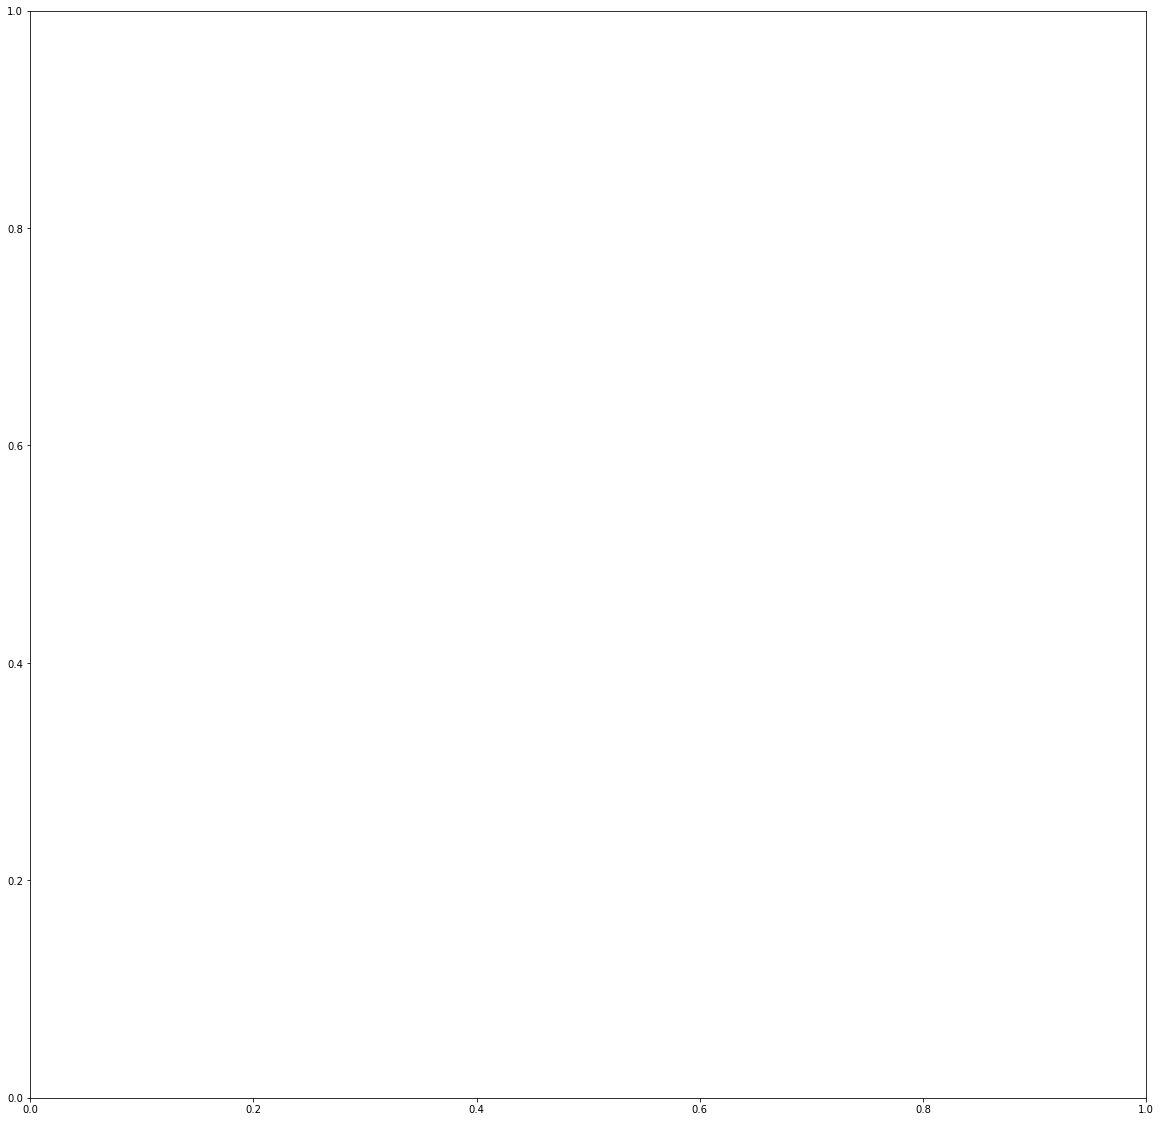

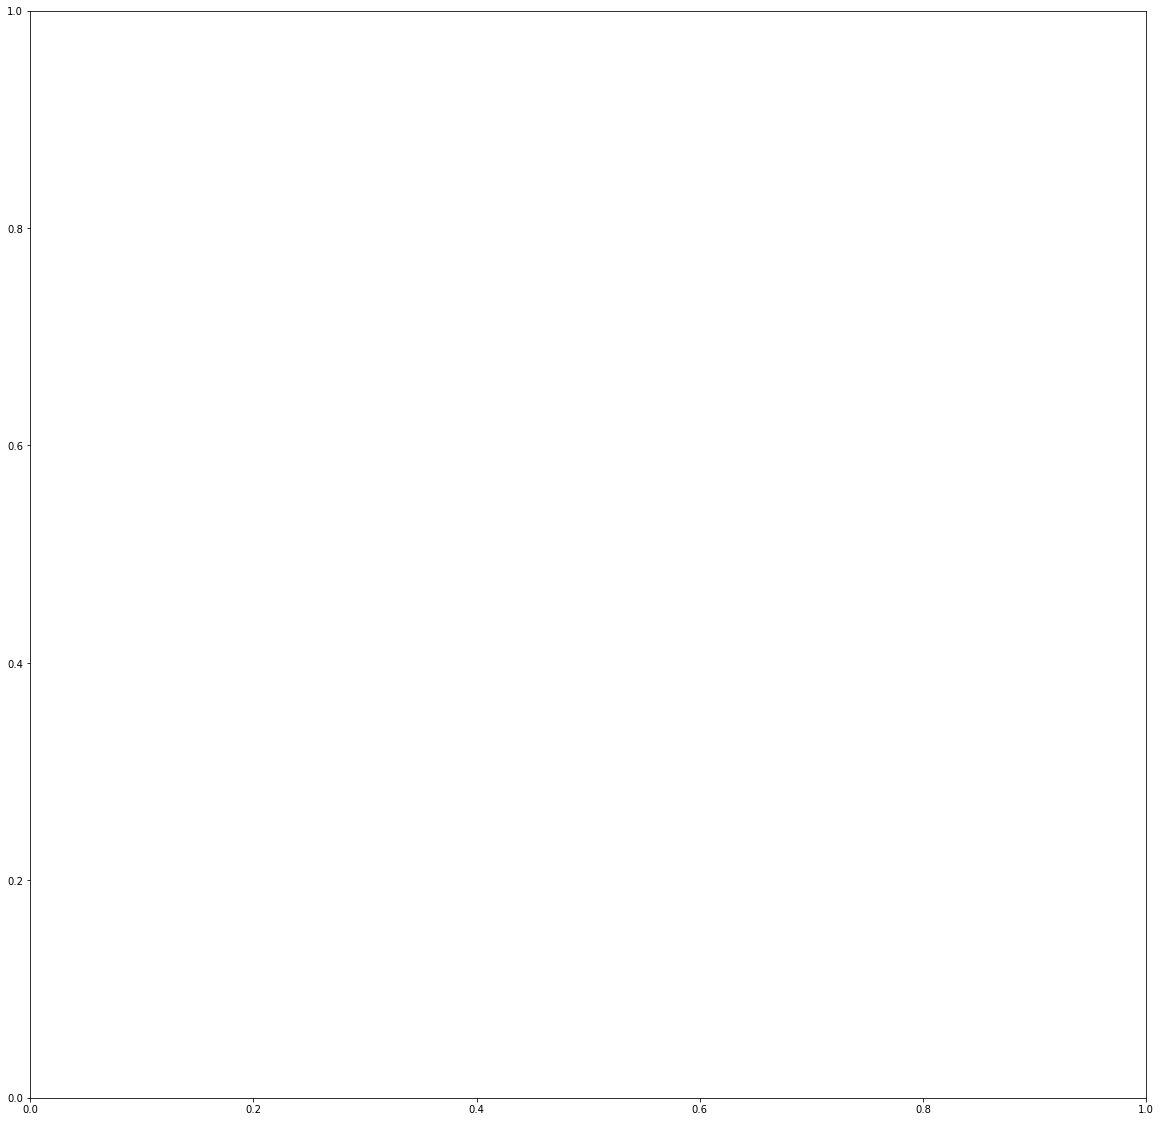

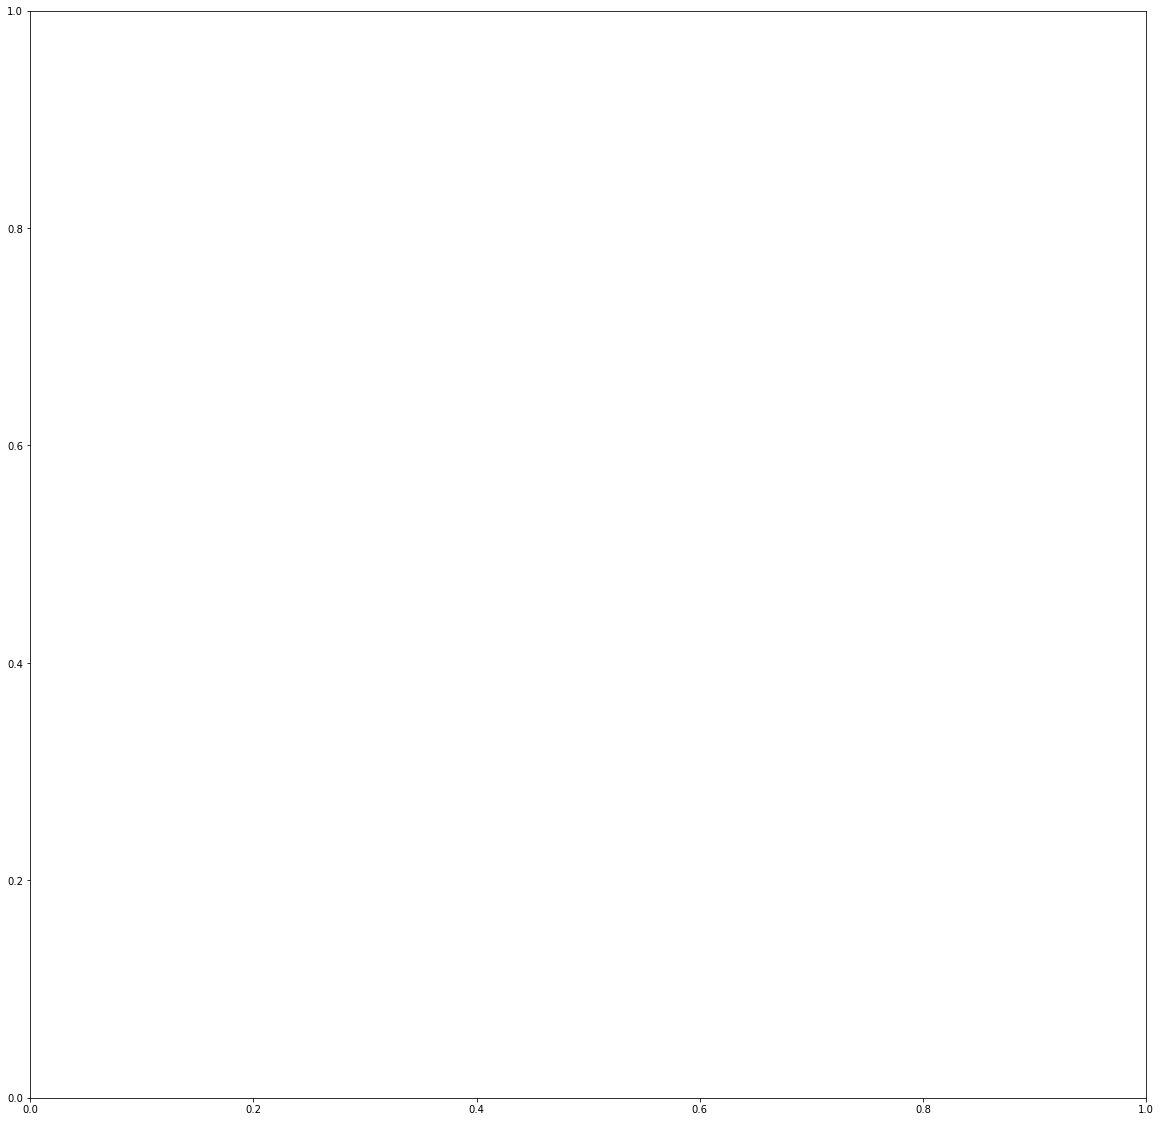

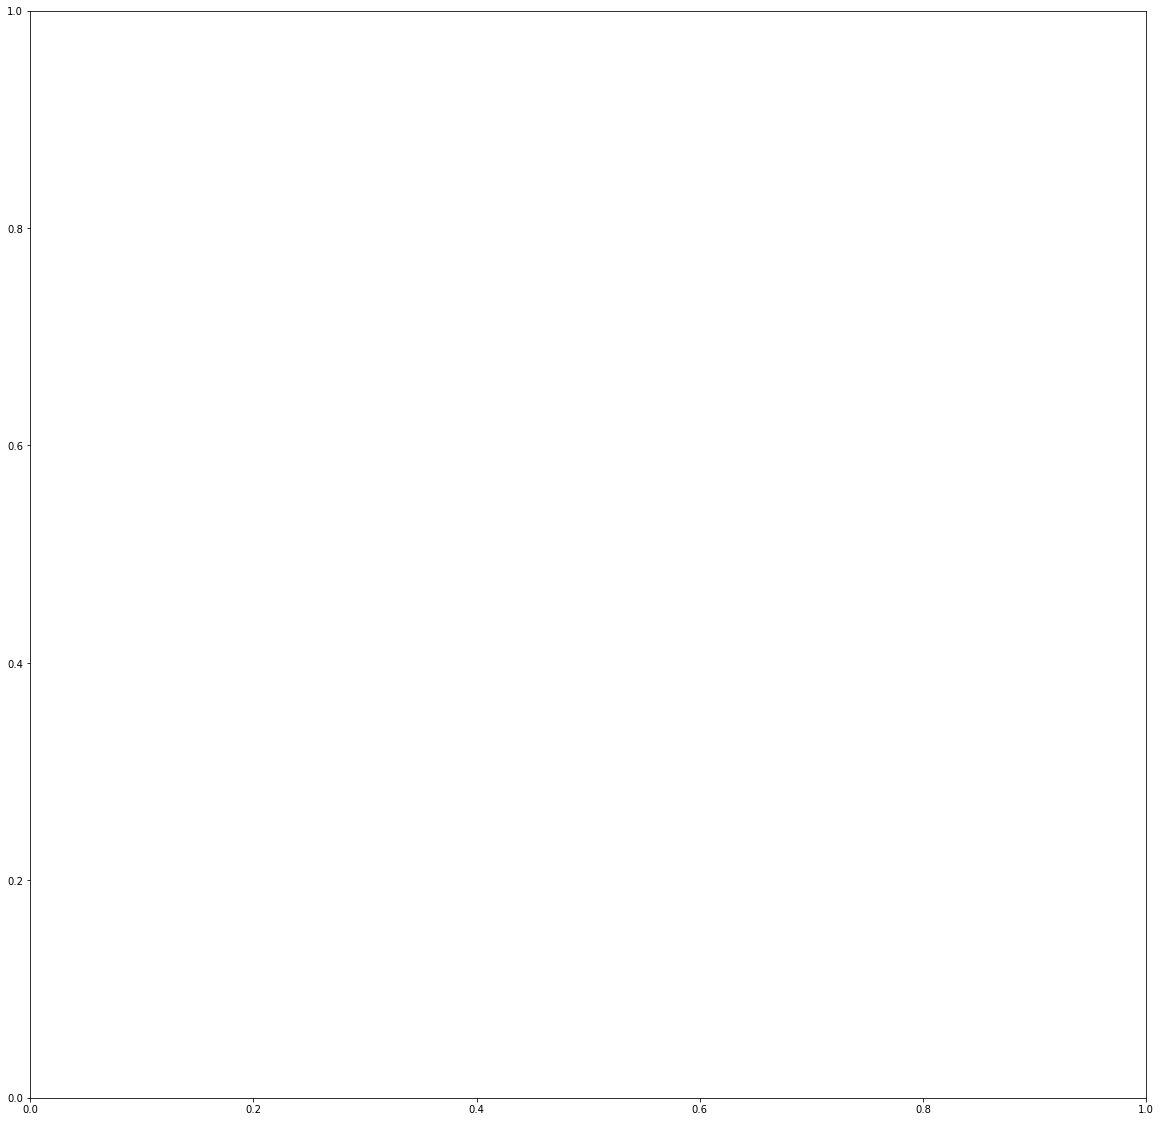

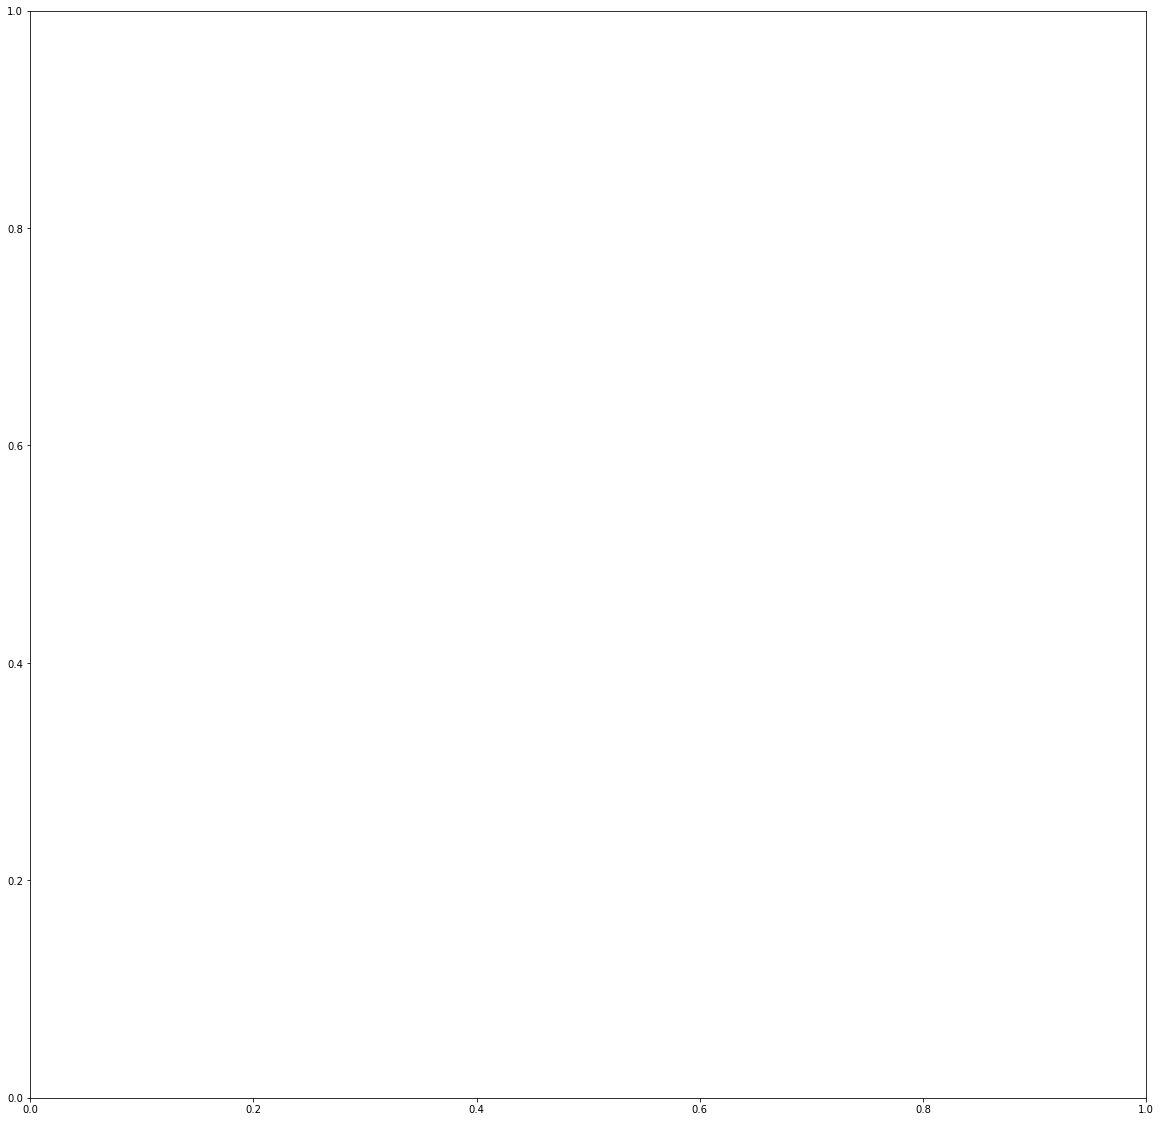

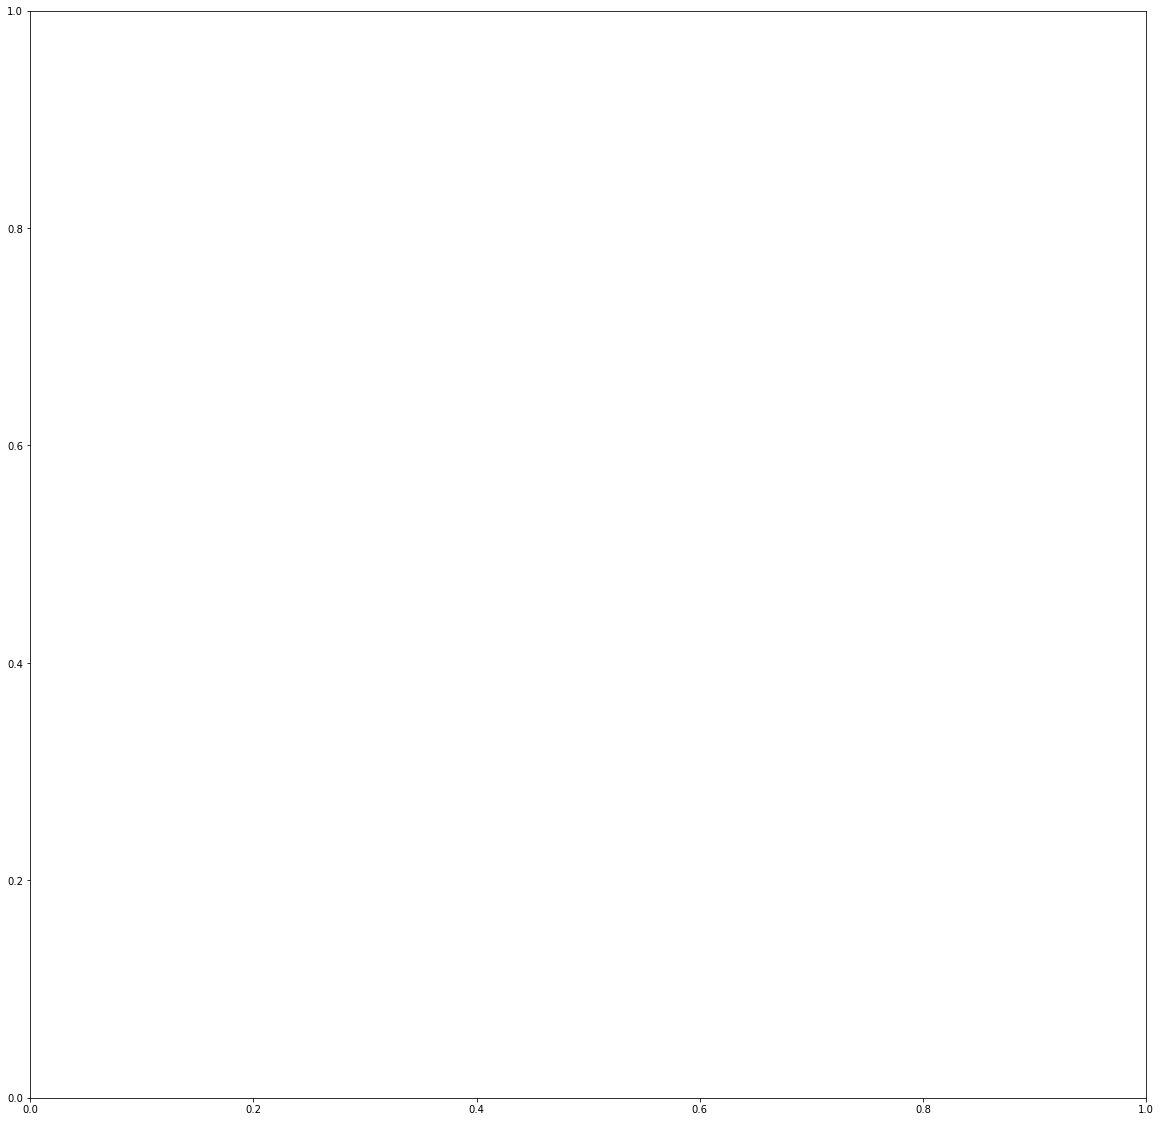

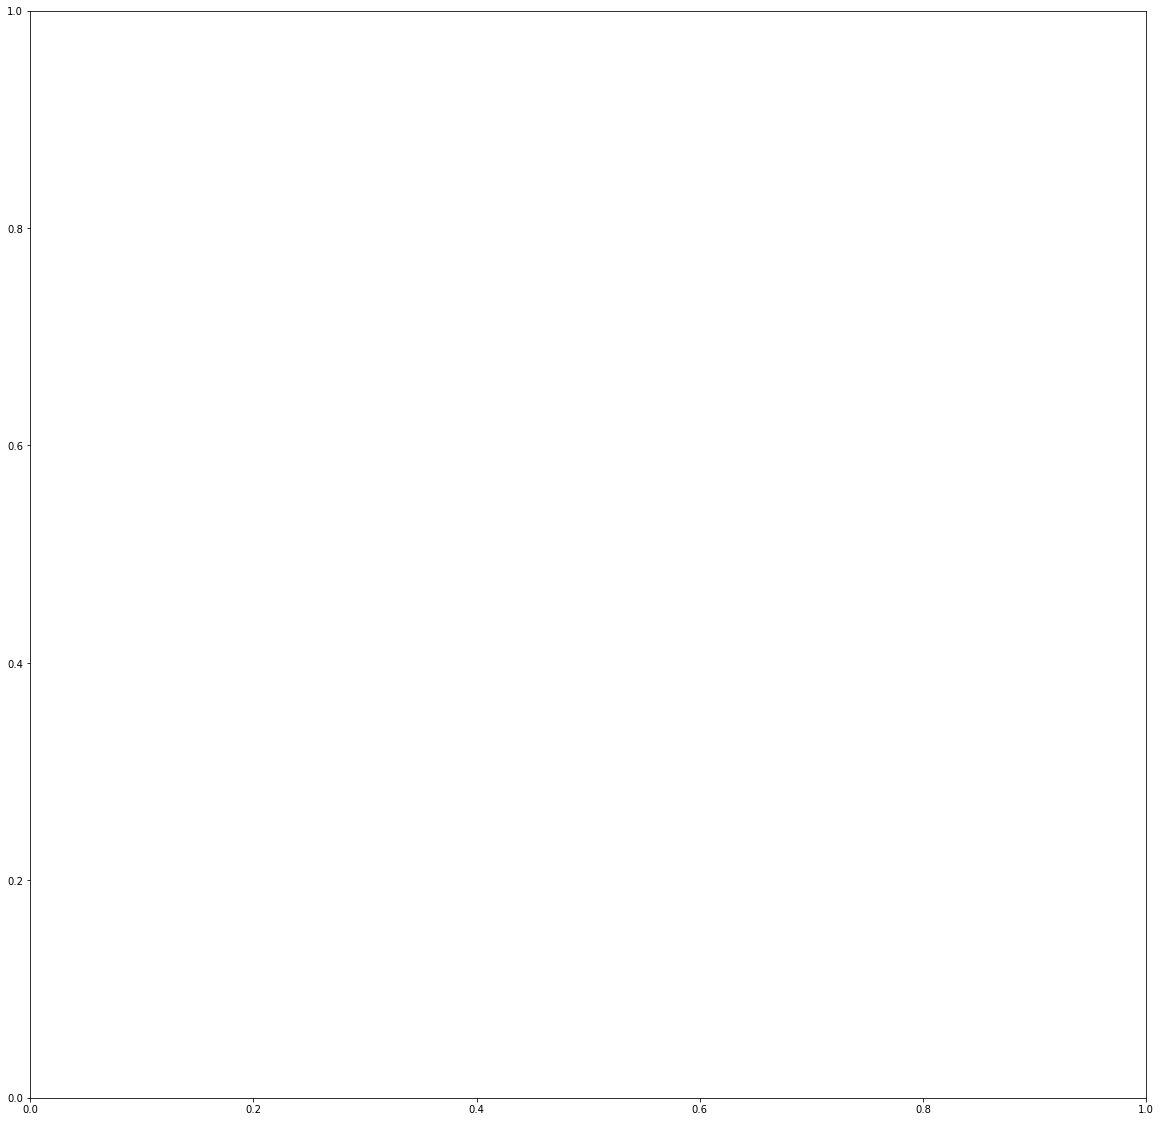

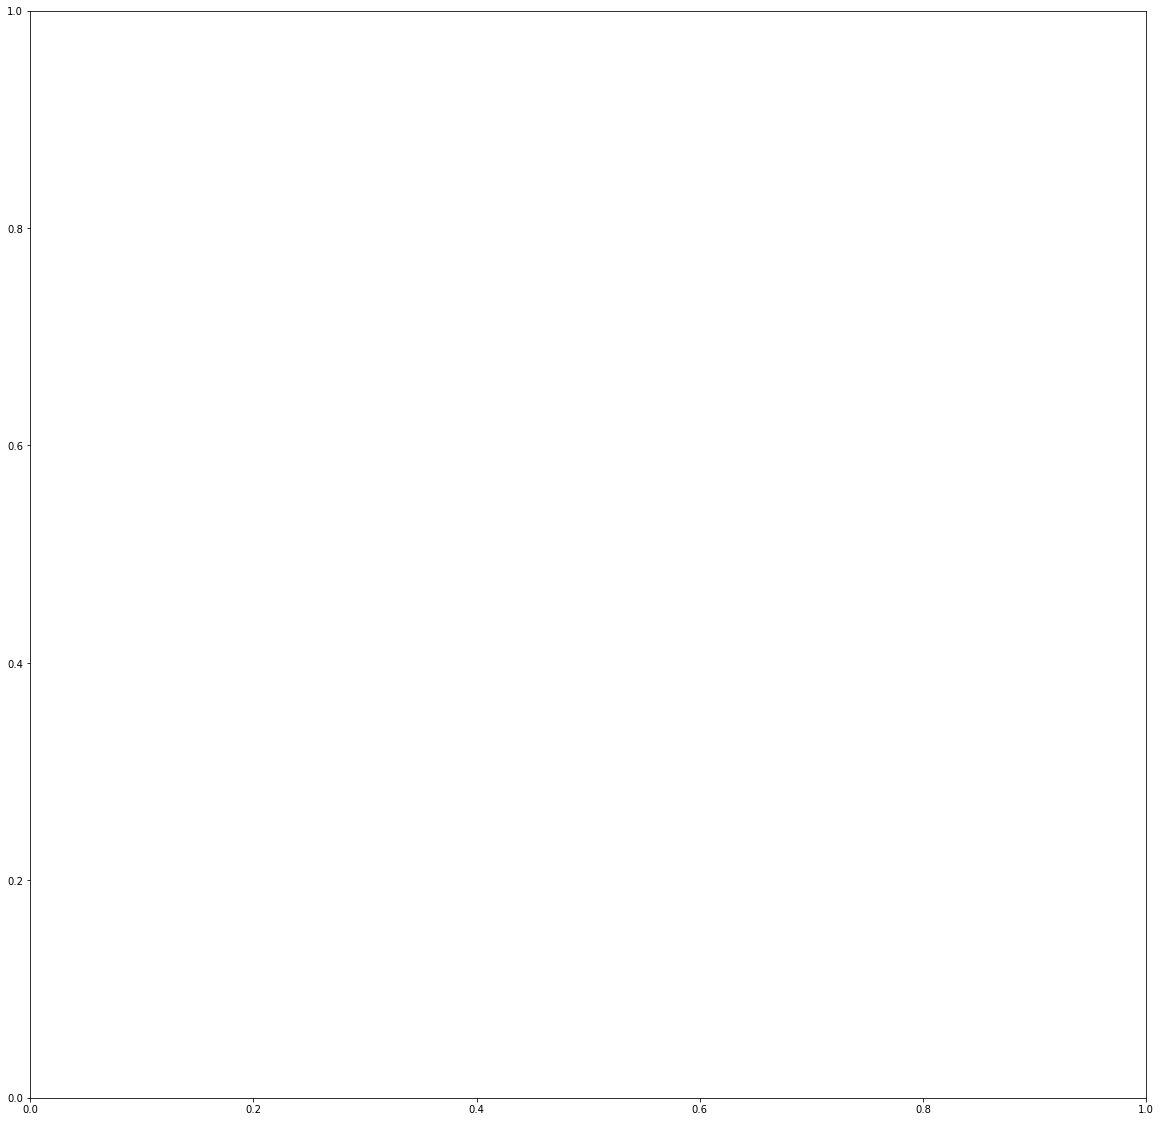

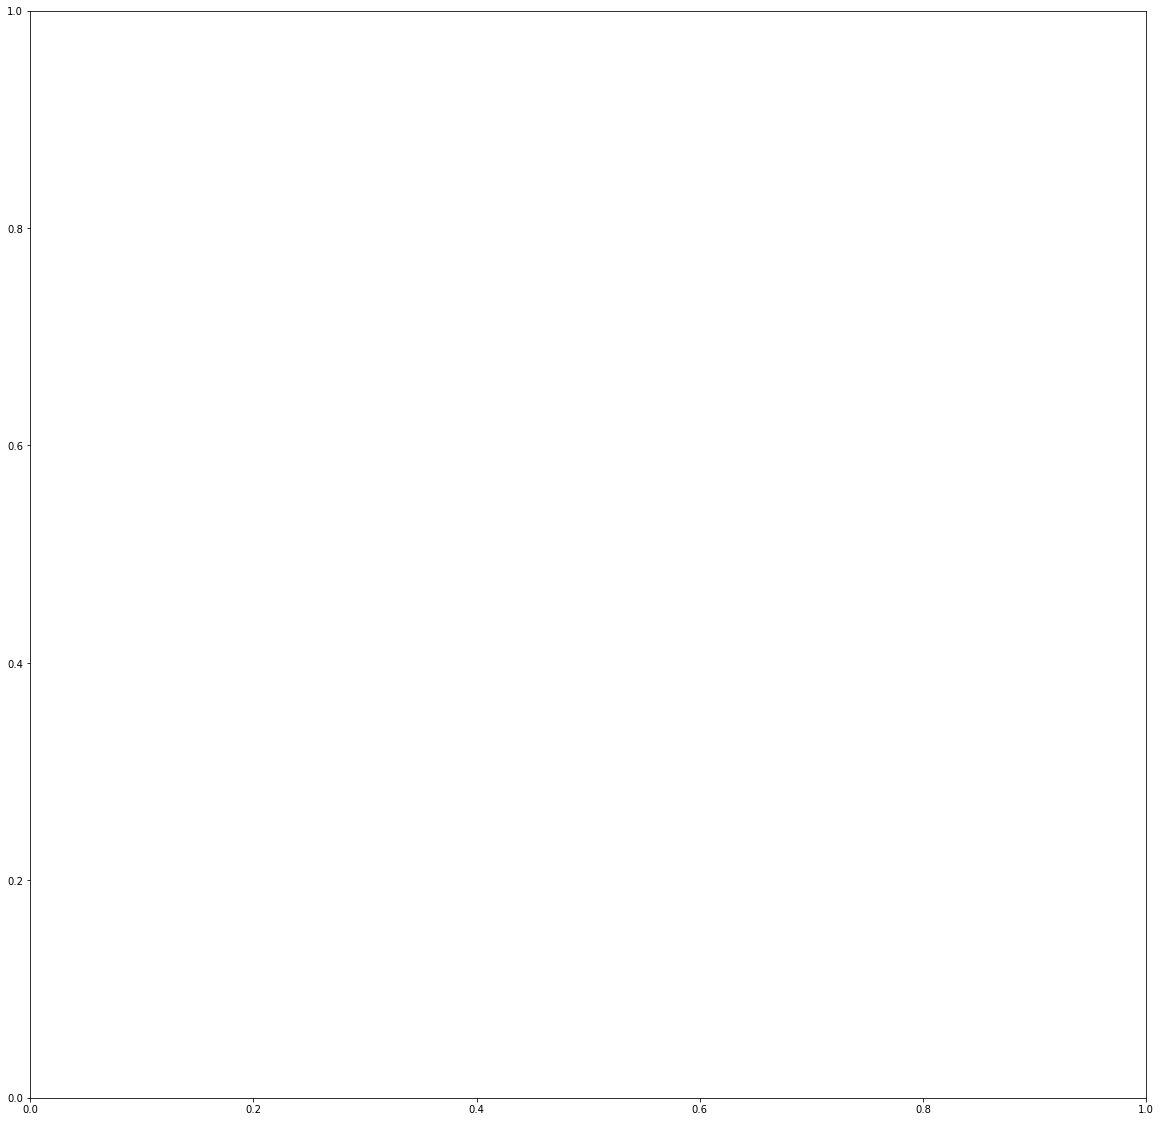

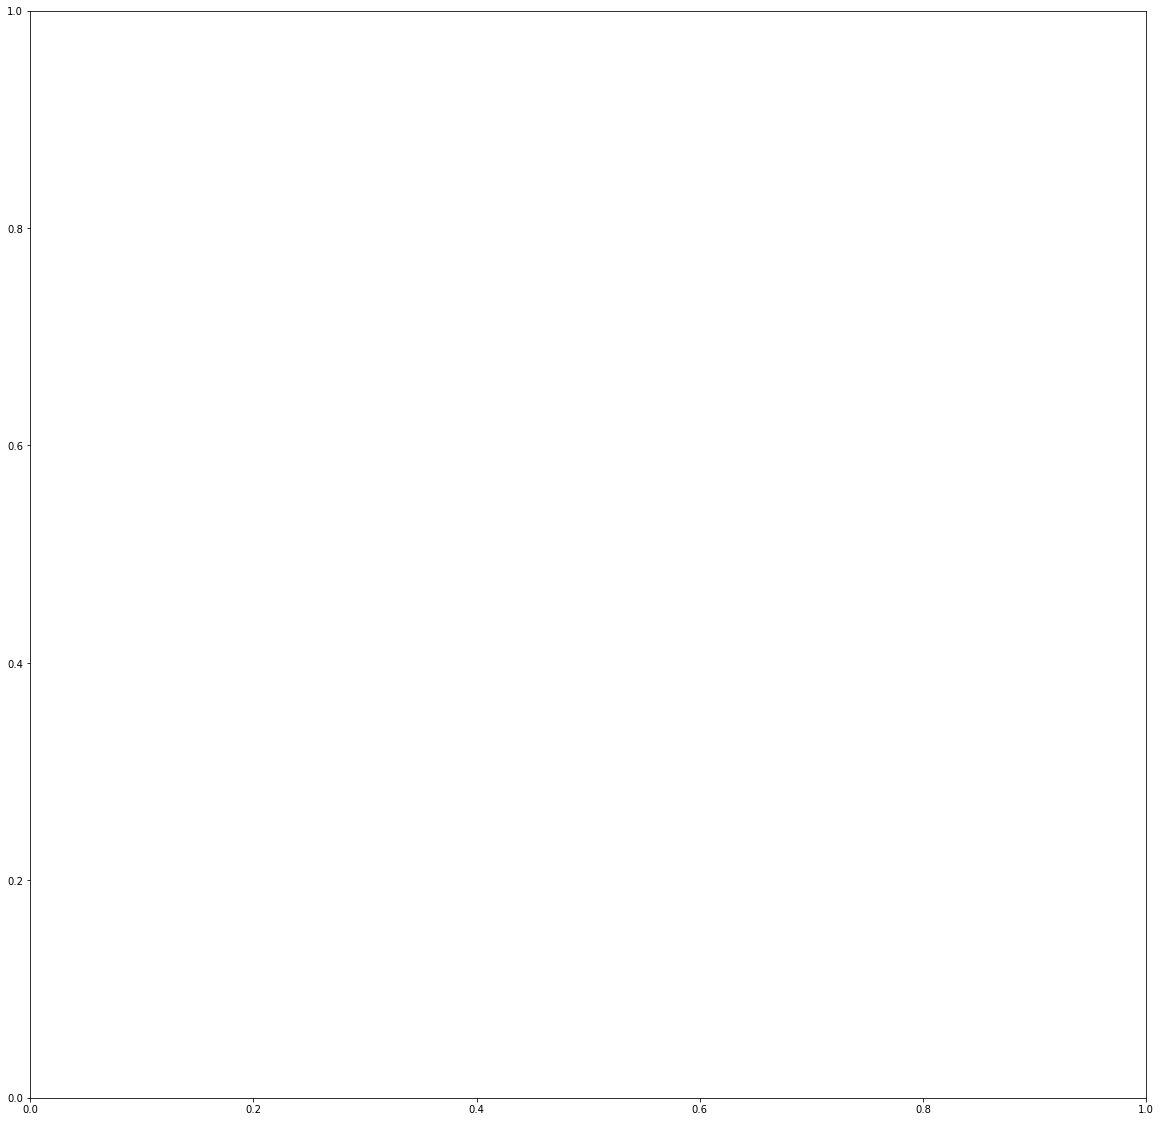

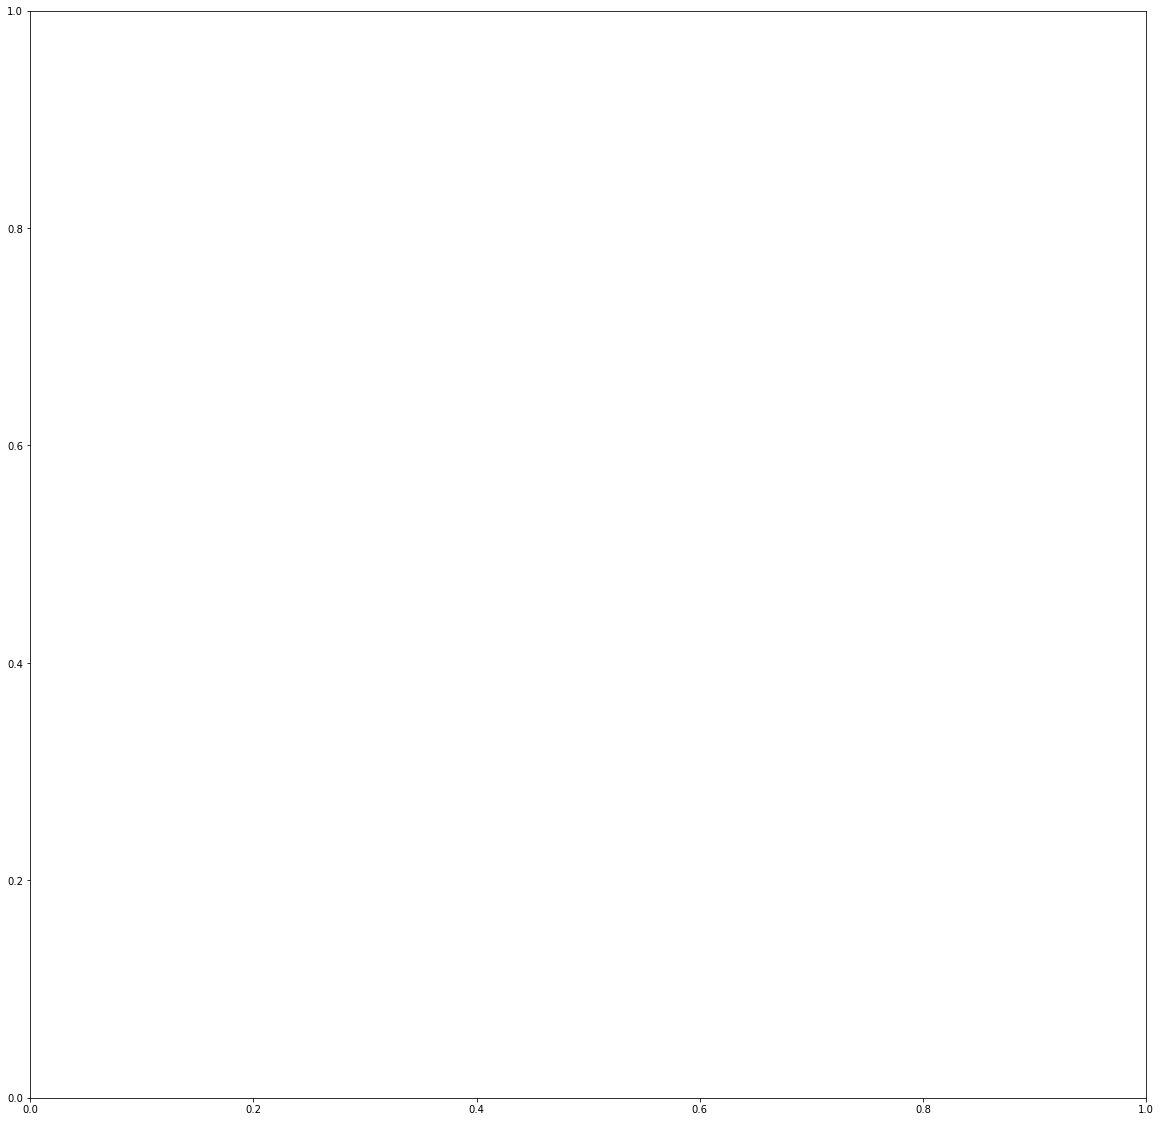

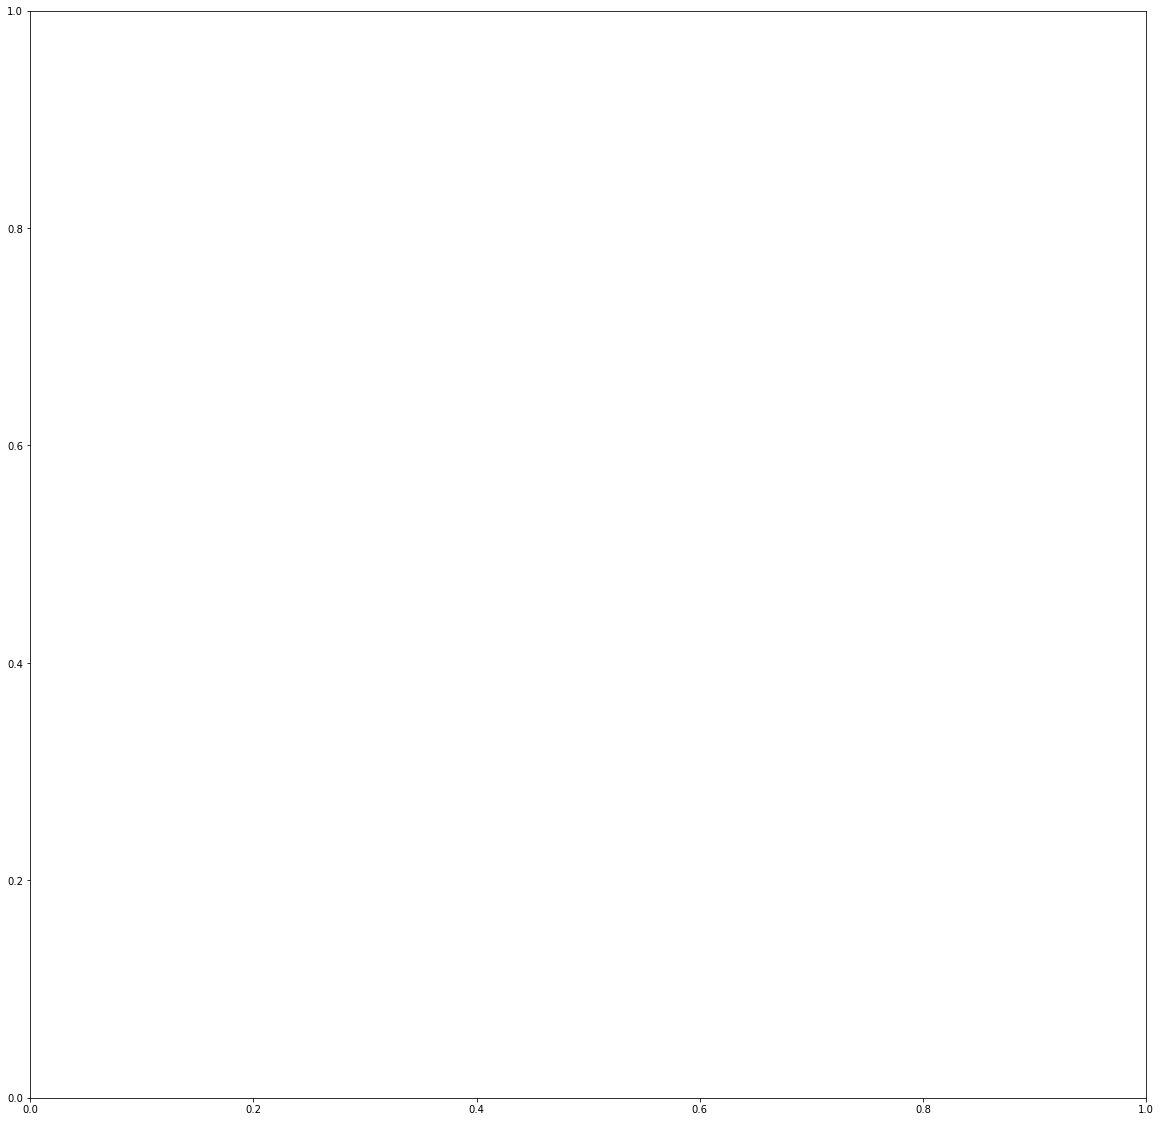

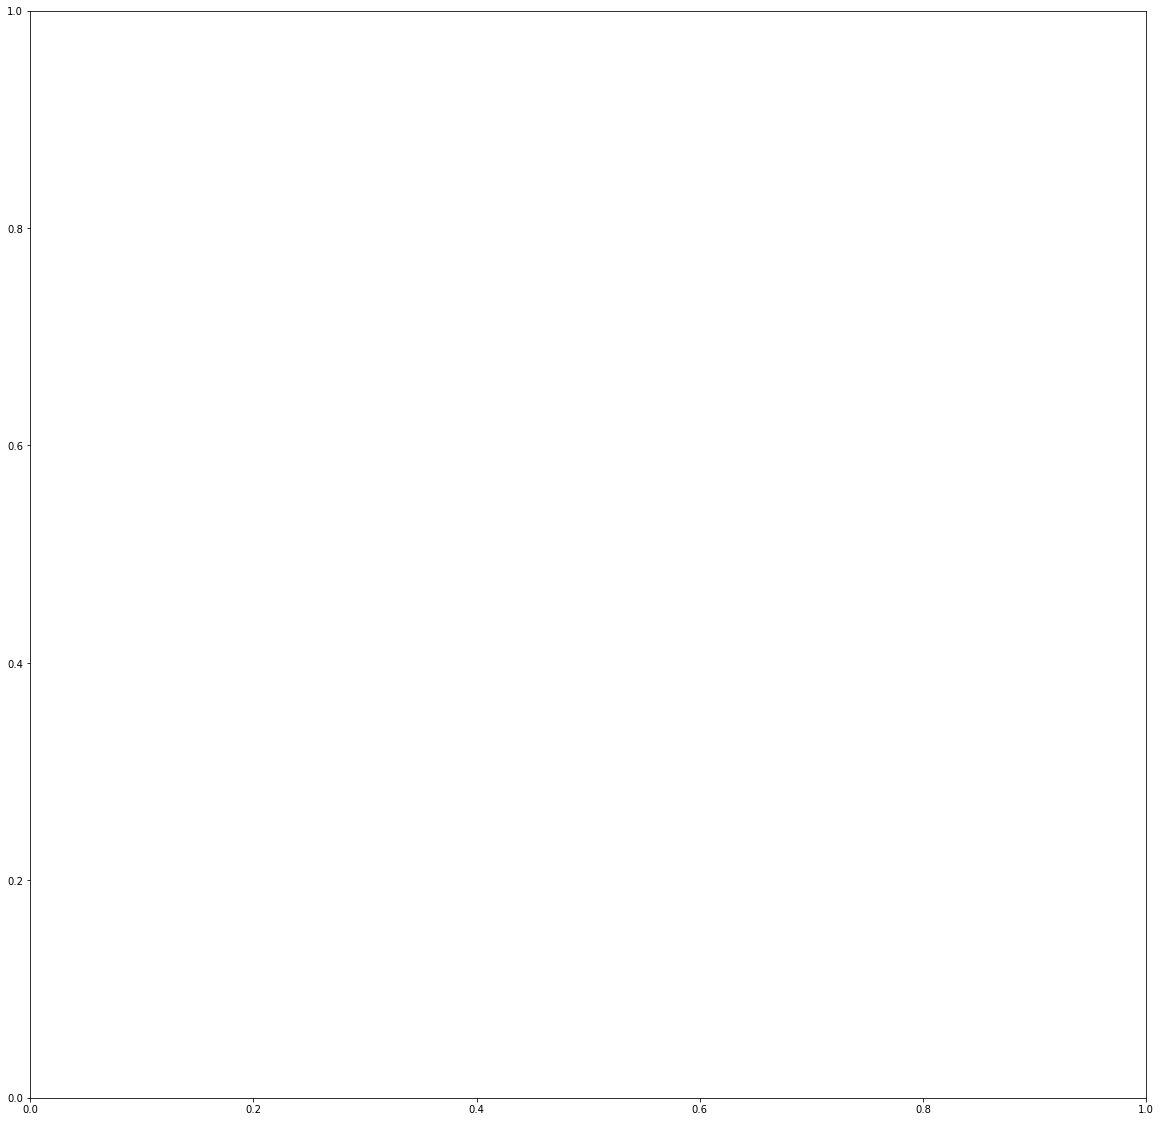

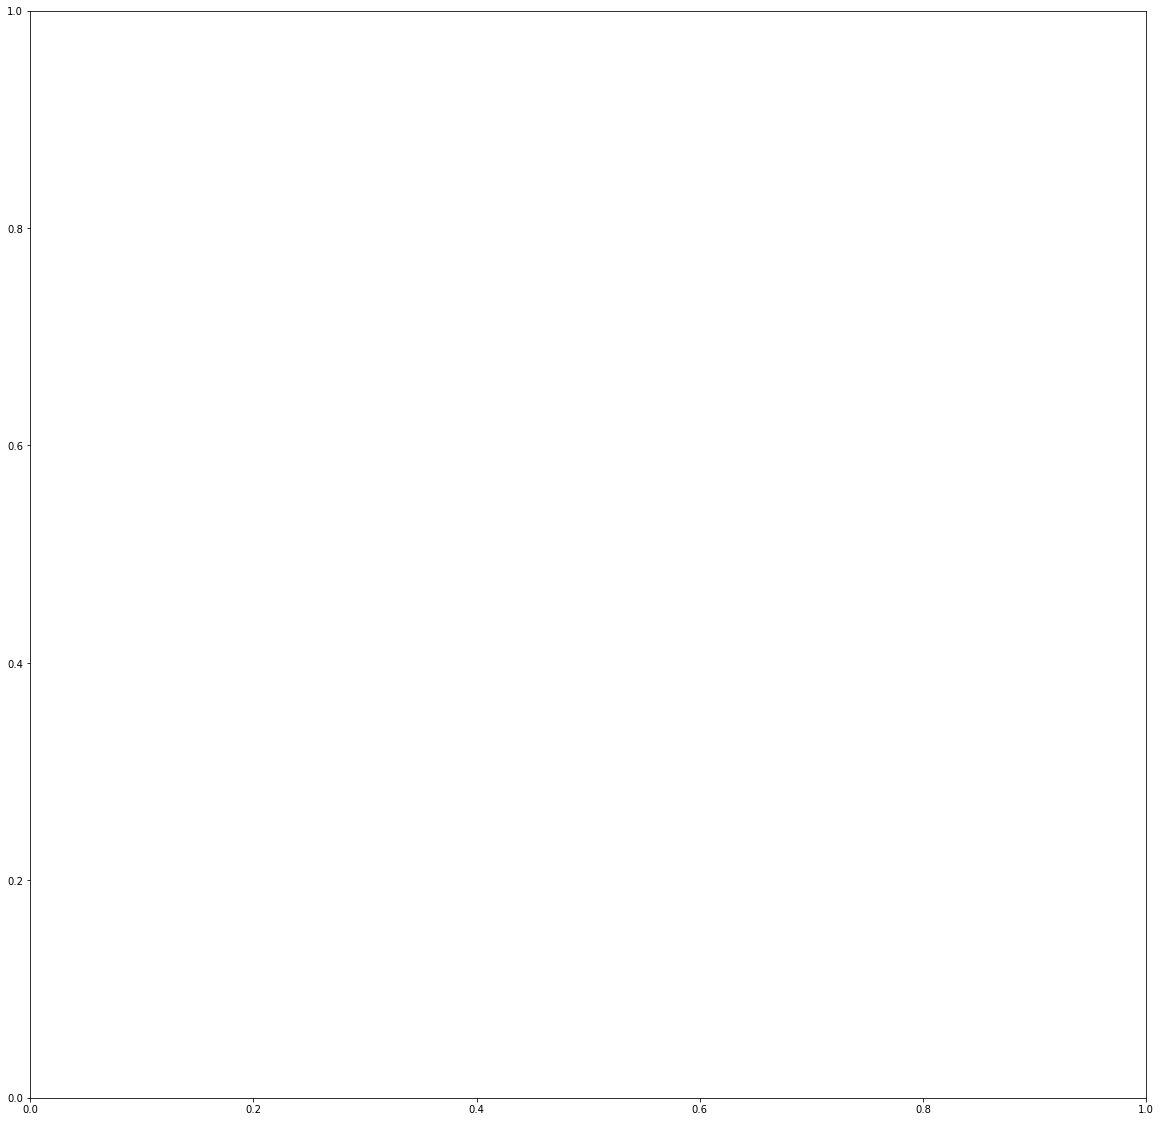

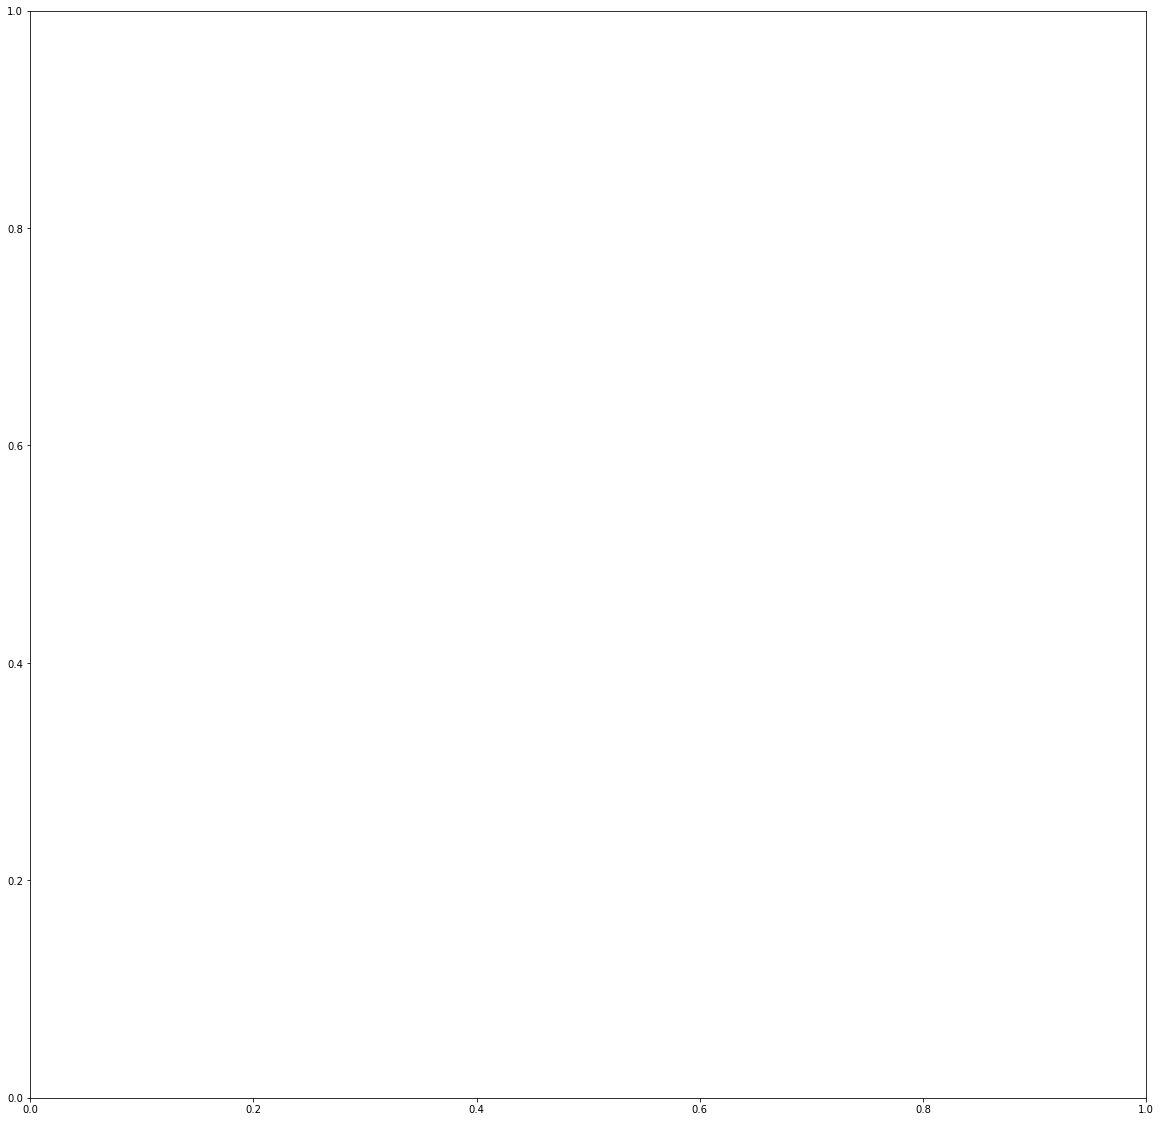

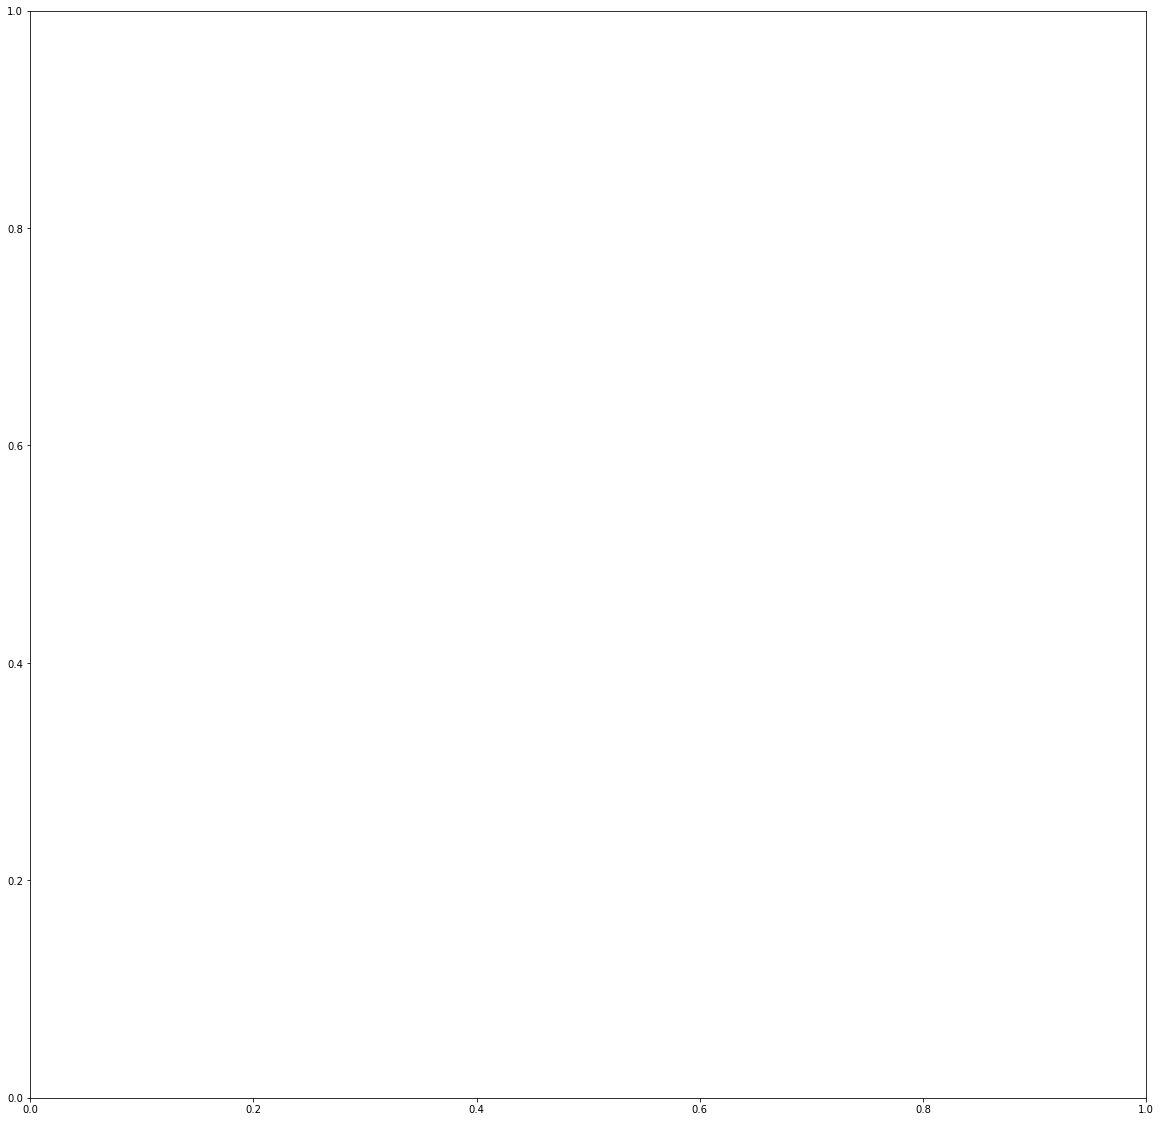

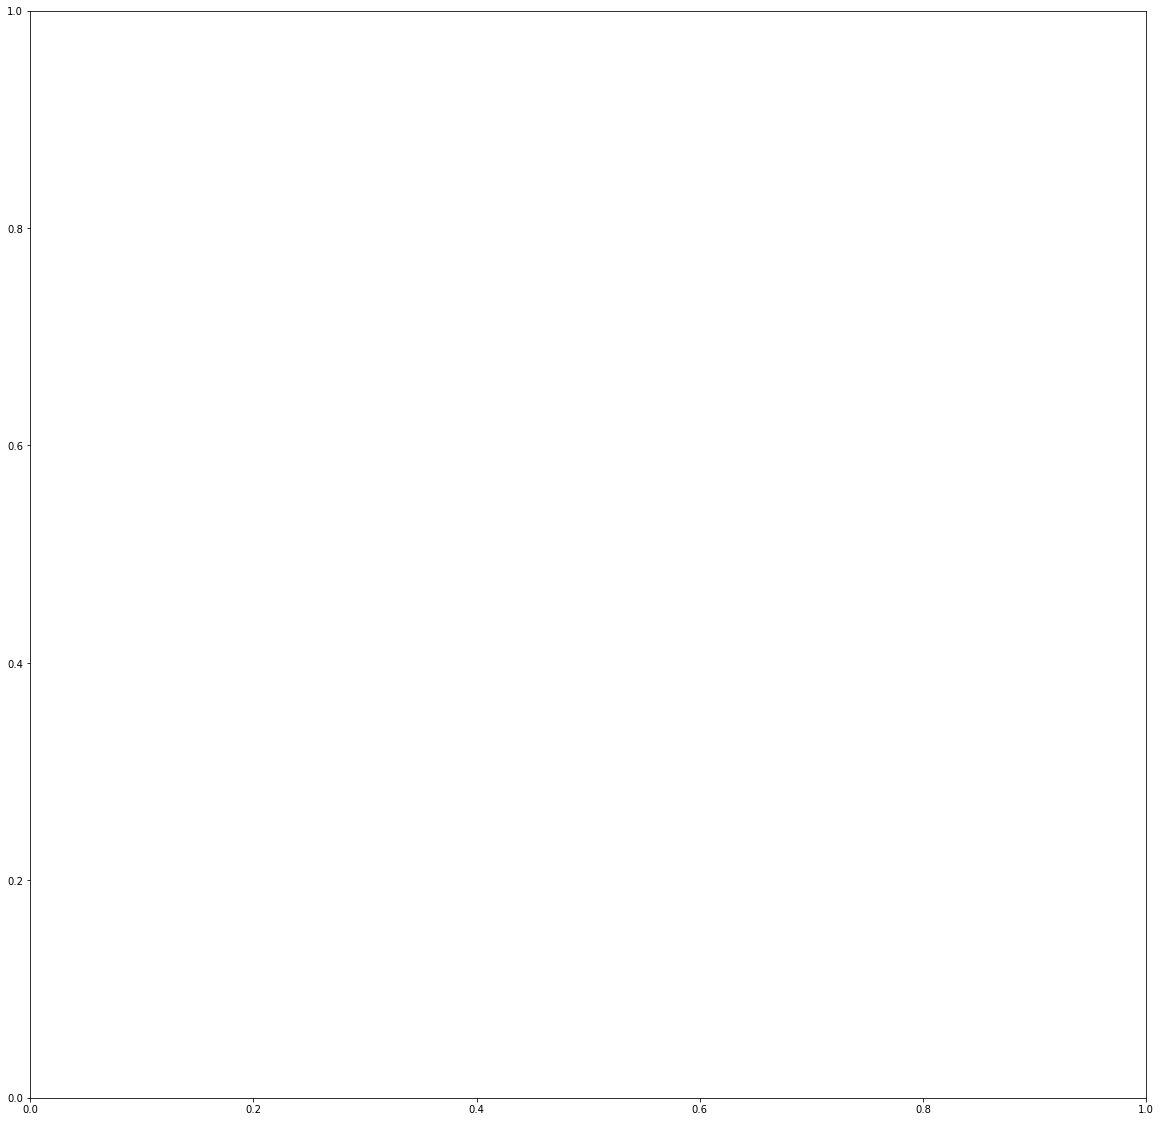

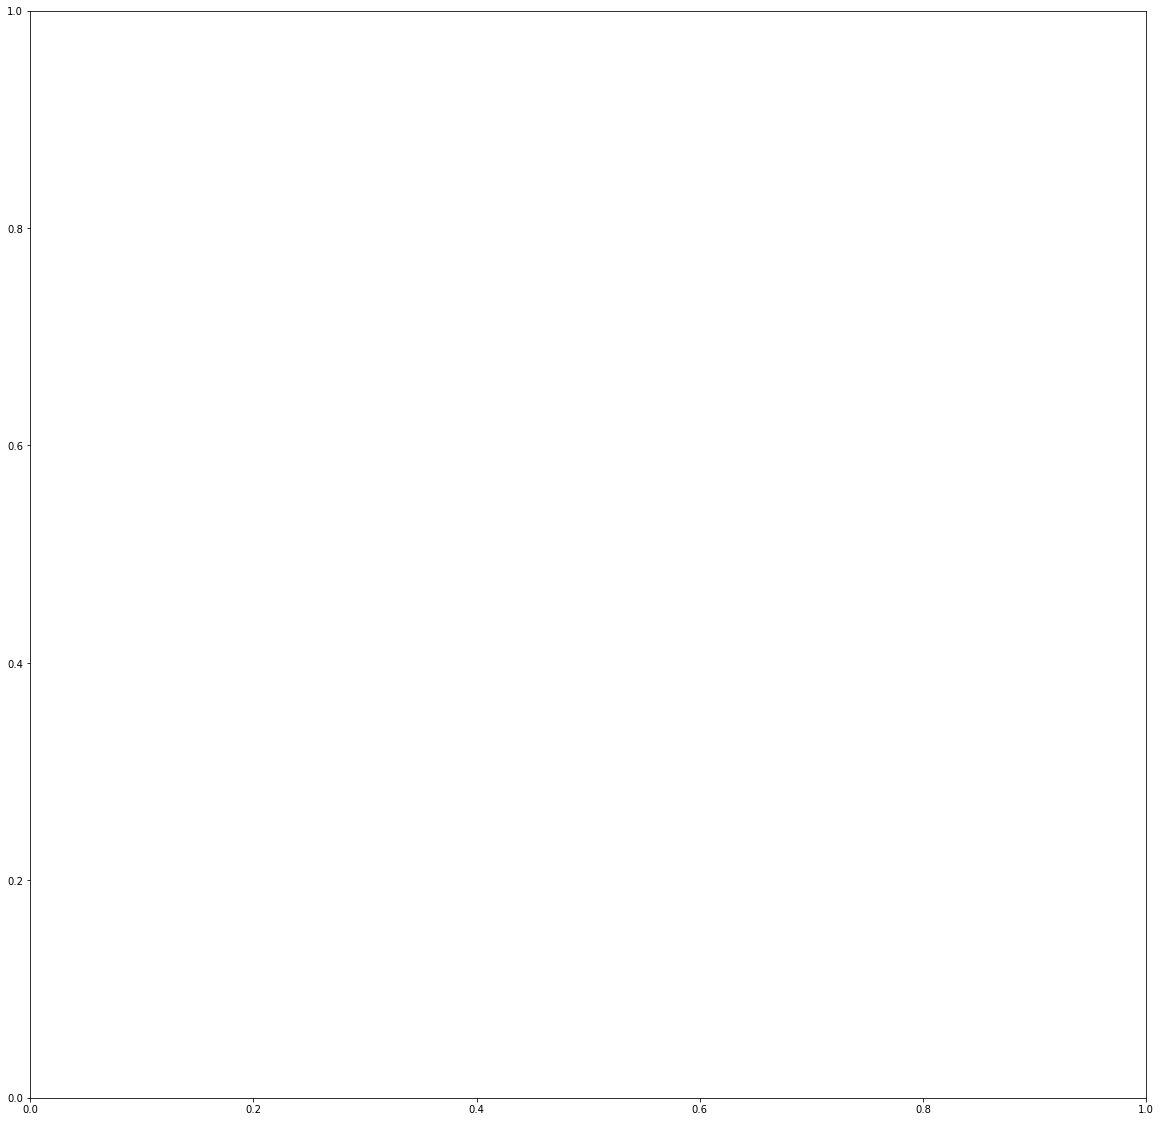

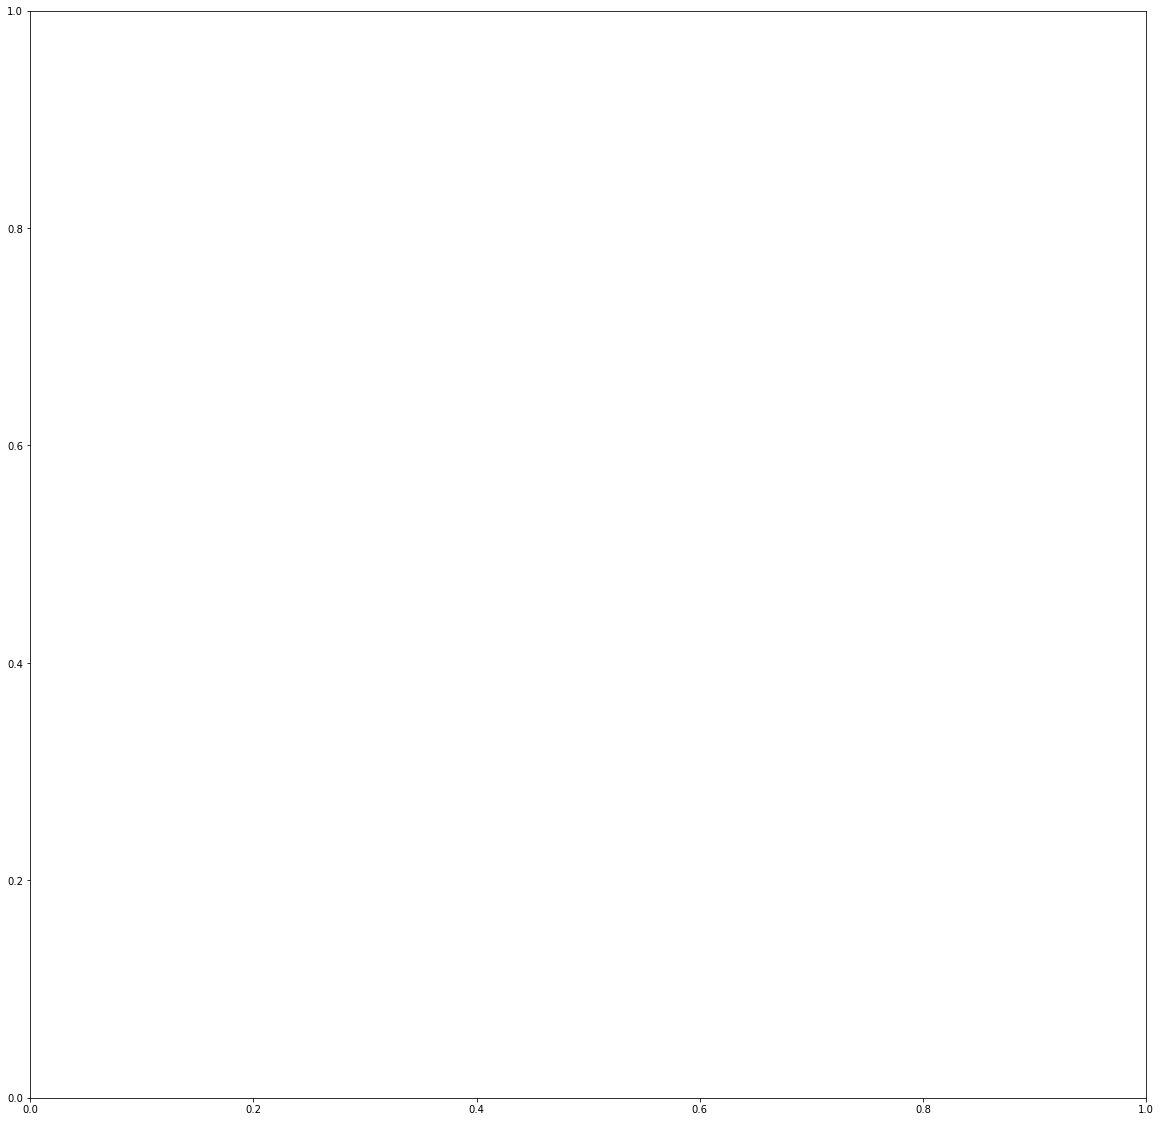

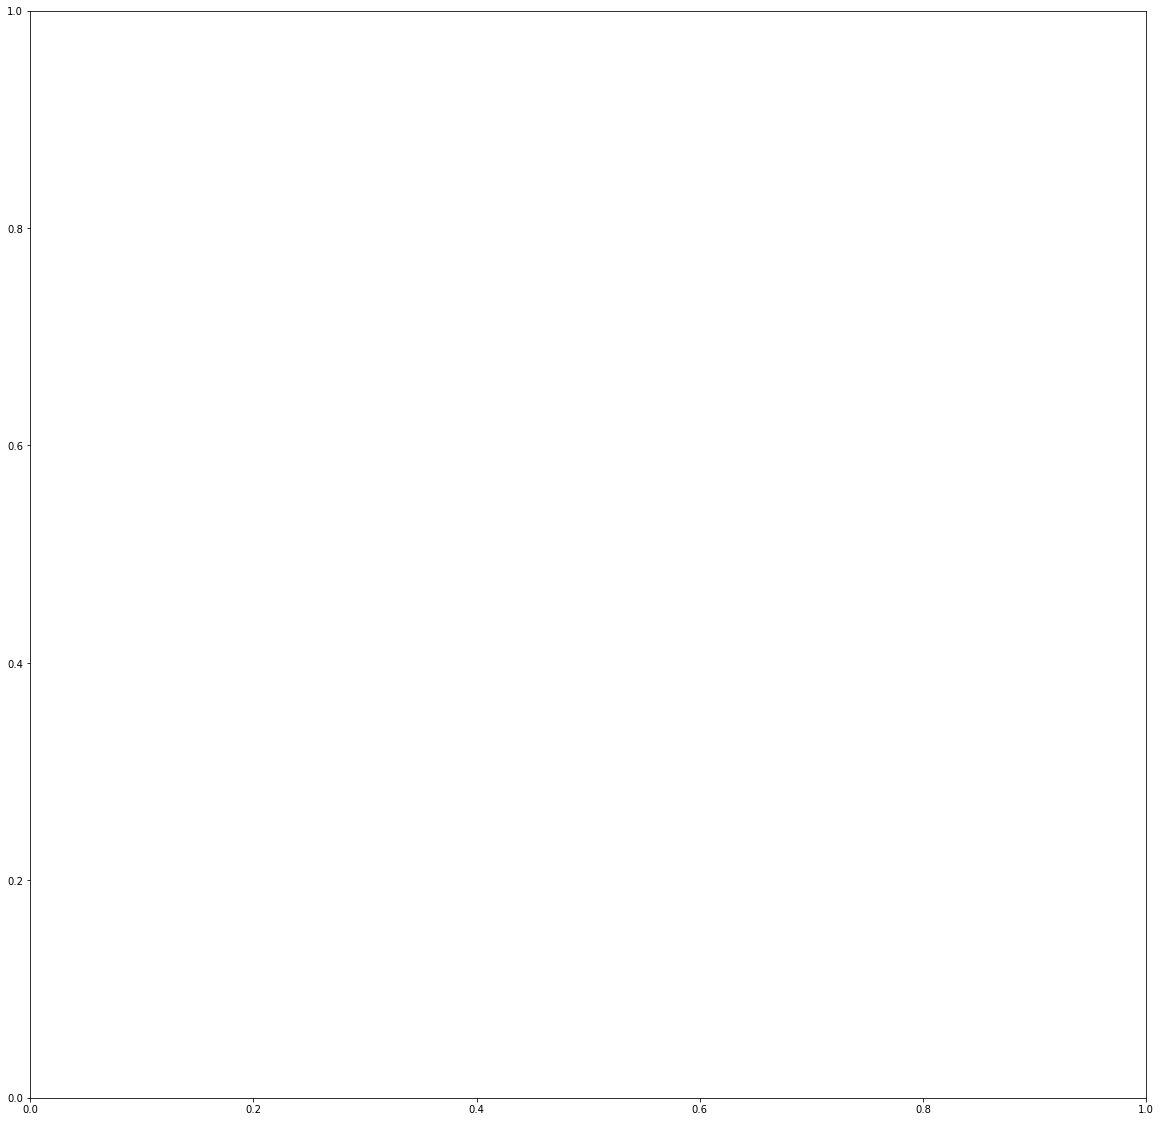

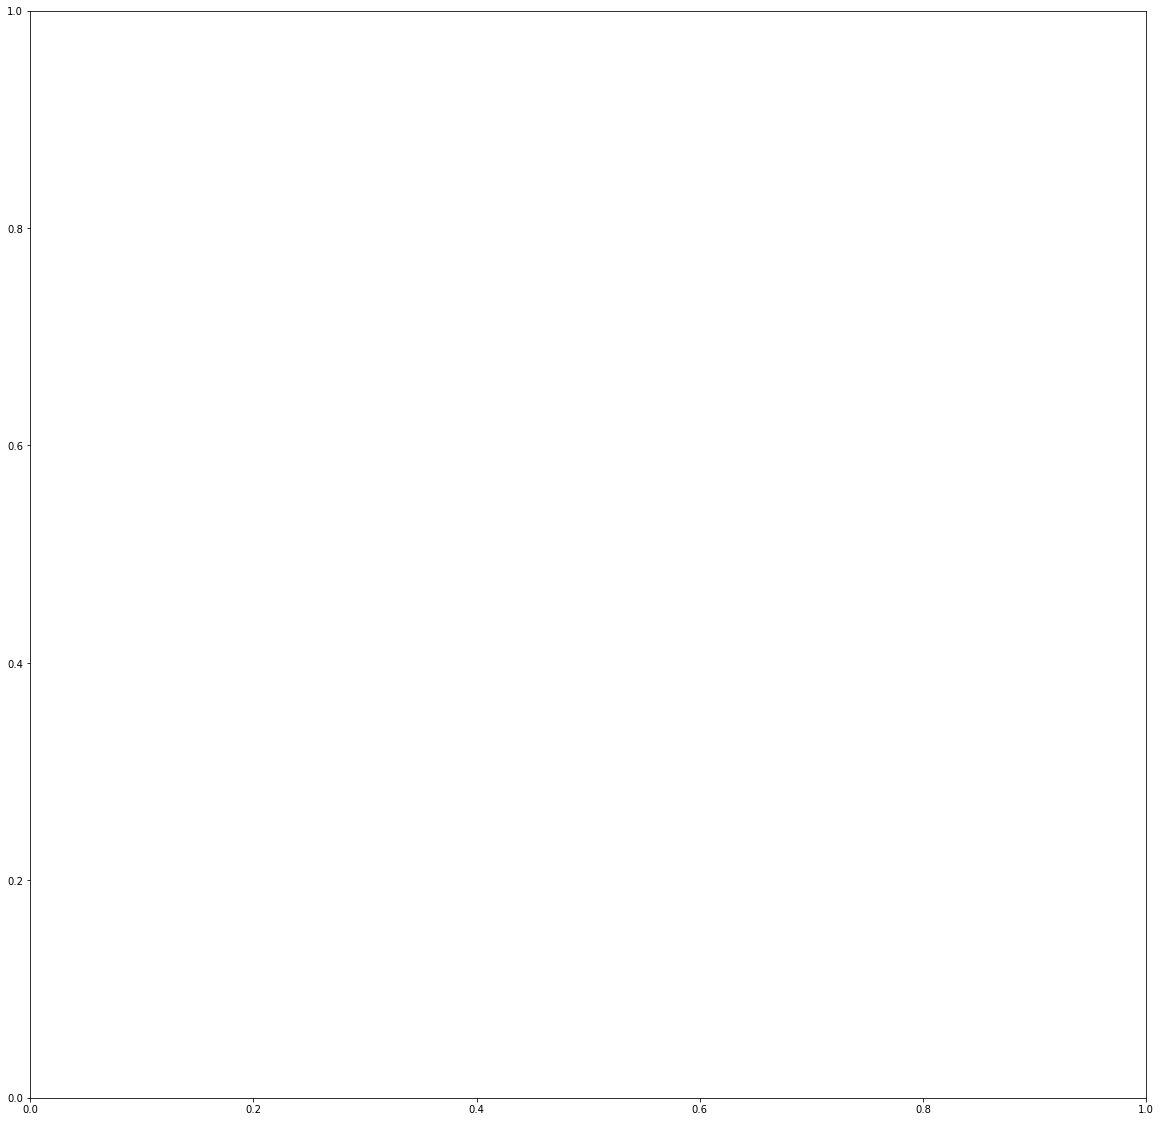

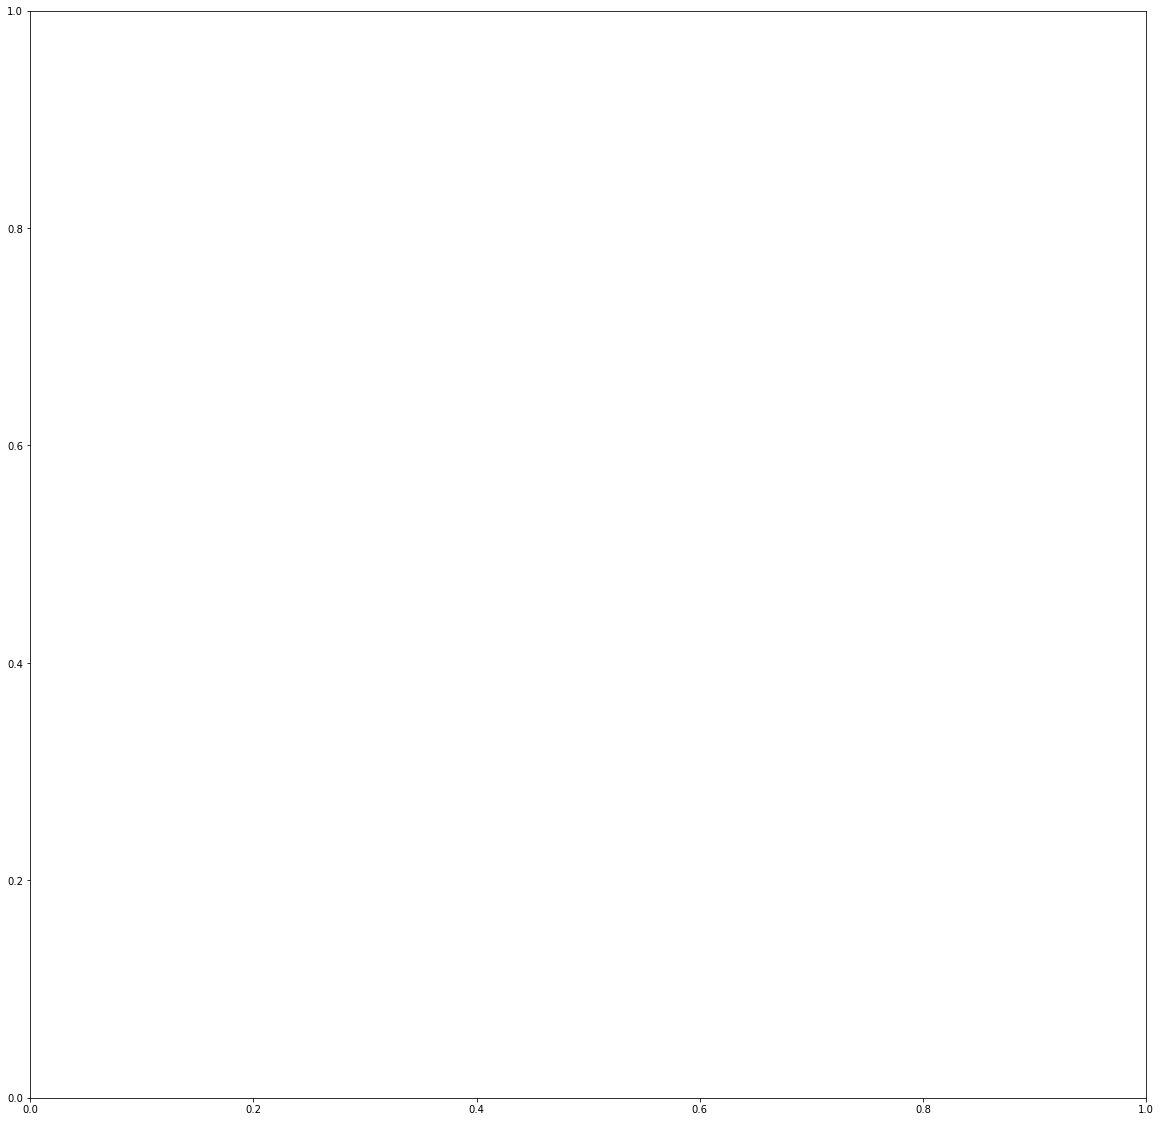

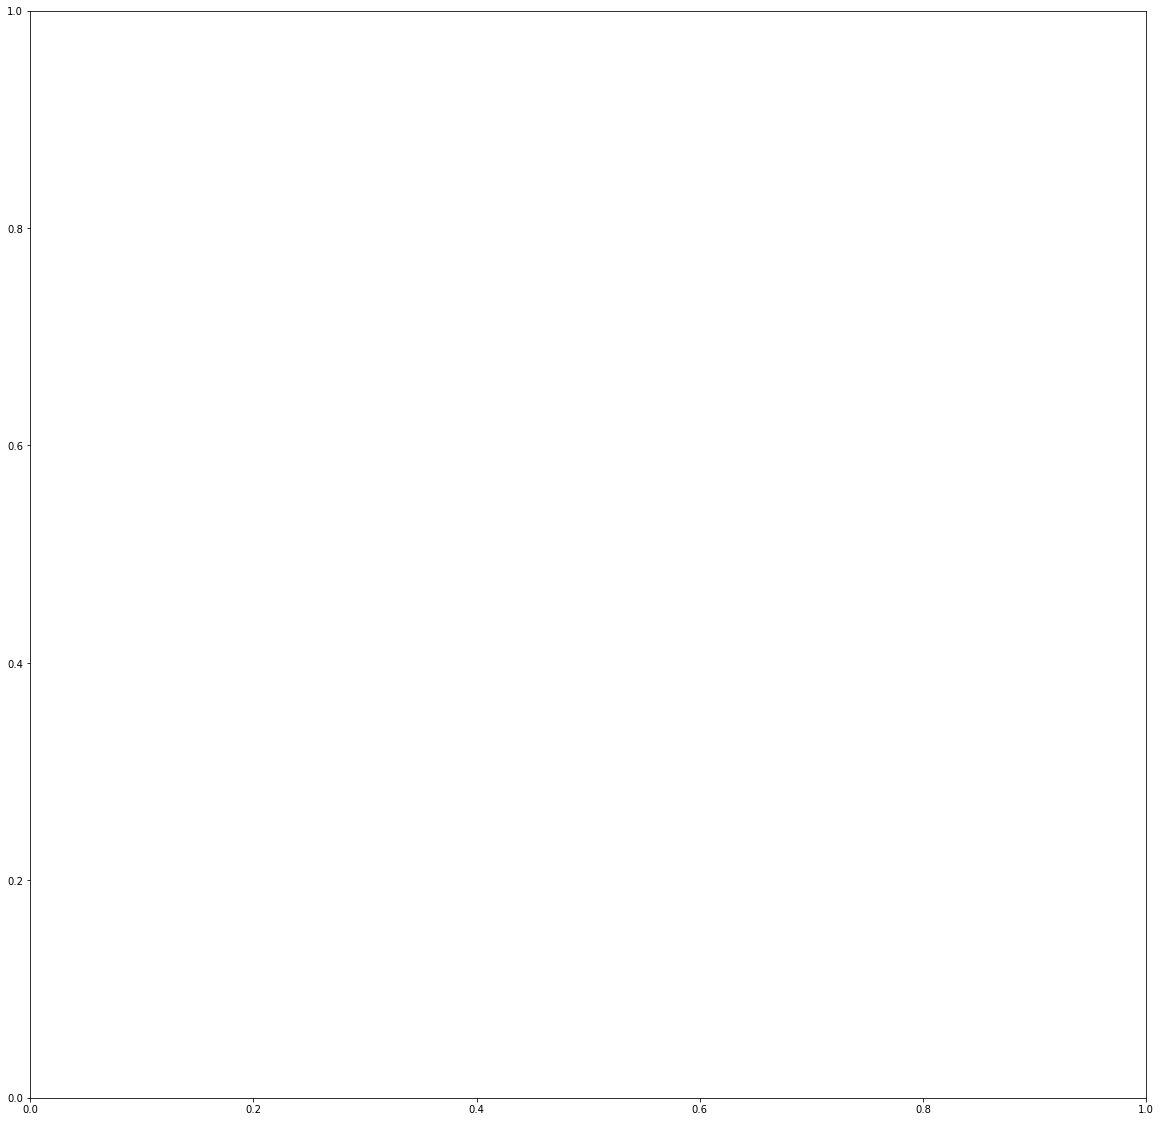

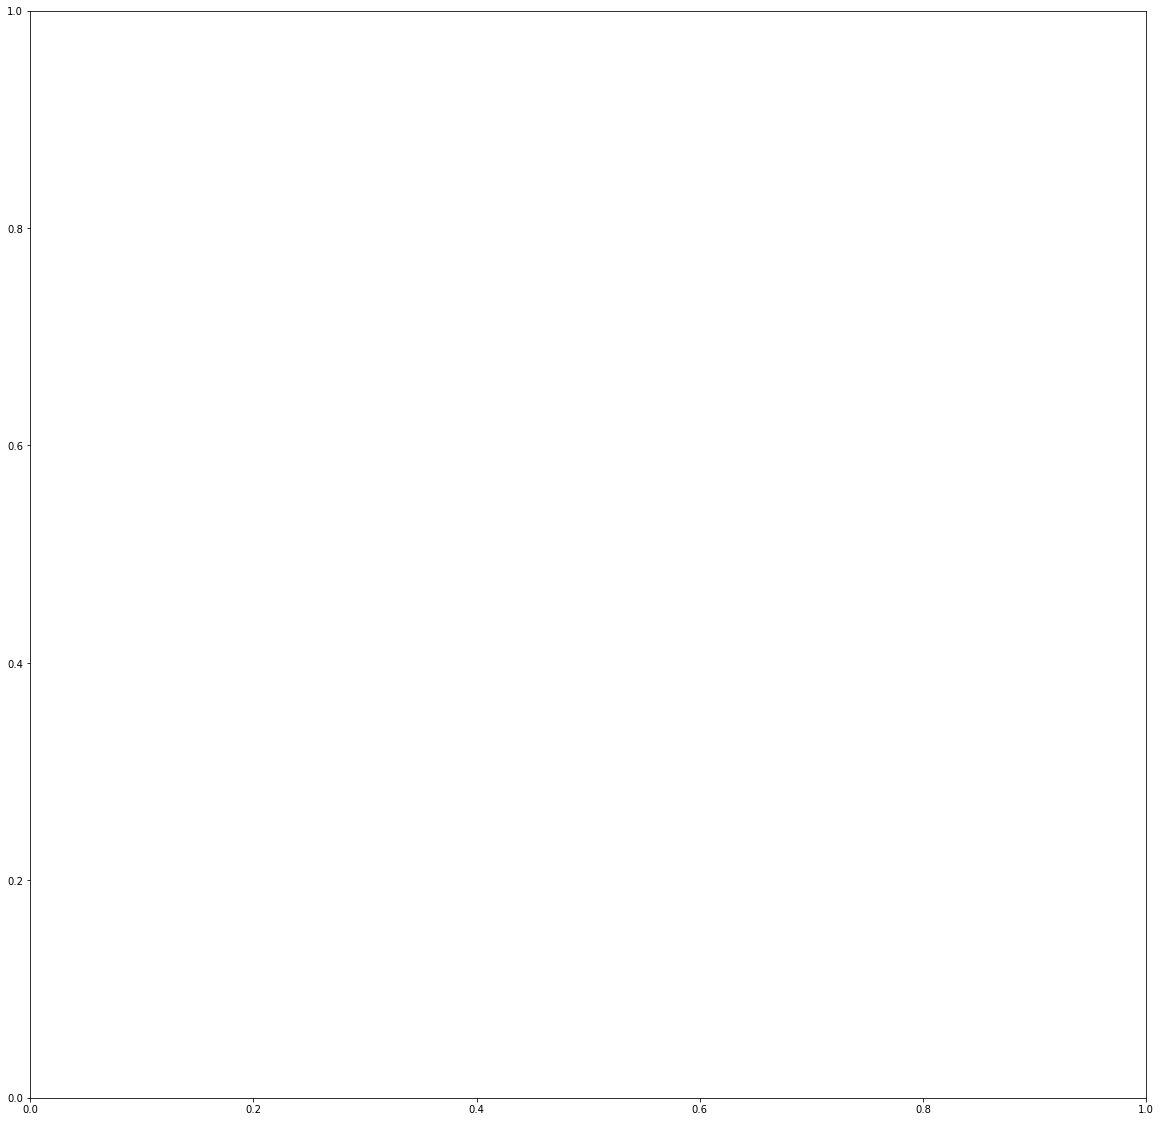

In [105]:
for j,stage in enumerate(a.obs["stage"].unique()[:]):

    b = a[a.obs["stage"]==stage]
        
    scp.tl.rank_genes_groups(b,groupby="louvain",method="wilcoxon",use_raw=False)
    n_genes = 200
        
    writer = pd.ExcelWriter("Tables/DE_"+stage+".xlsx", engine='xlsxwriter')
    for k,group in enumerate(b.uns["rank_genes_groups"]["names"].dtype.names):
            
        l = pd.DataFrame(columns=["names","logfoldchanges","pvals","pvals_adj","scores"])
        l.loc[:,"names"] = b.var.loc[[n[k] for n in b.uns["rank_genes_groups"]["names"]][:n_genes],"Gene"].values
        l.loc[:,"logfoldchanges"] = [n[k] for n in b.uns["rank_genes_groups"]["logfoldchanges"]][:n_genes]
        l.loc[:,"pvals"] = [n[k] for n in b.uns["rank_genes_groups"]["pvals"]][:n_genes]
        l.loc[:,"pvals_adj"] = [n[k] for n in b.uns["rank_genes_groups"]["pvals_adj"]][:n_genes]
        l.loc[:,"scores"] = [n[k] for n in b.uns["rank_genes_groups"]["scores"]][:n_genes]
        
        l.to_excel(writer, sheet_name="cluster_"+str(k))
        
    writer.save()
    
    X = b.obsm["X_umap_harmony_stages"]
    
    if not os.path.exists("Plots/UMAP_genes/Genes_"+stage): #Make if it does not exist
        os.makedirs("Plots/UMAP_genes/Genes_"+stage)
    
    exp = []
    for k in geneList:
        try:
            fig,ax = plt.subplots(1,1,figsize=[20,20])
            hue = b[:,b.var.loc[:,"Gene"]==k].X.toarray()[:,0]
            pos = np.argsort(hue)

            sb.scatterplot(X[pos,0],X[pos,1],hue=hue[pos],s=50,ax=ax)
            ax.set_title(k,fontsize=40)
            fig.savefig("Plots/UMAP_genes/Genes_"+stage+"/"+k+".png",bbox_inches="tight",transparent=False)
            plt.close(fig)
        except:
            if k not in exp:
                exp.append(k)
            
print(exp, " don't express")

## Create excel for new annotations with old annotations matches.

In [107]:
old_annotations = "Annotation_2021_08.csv"

In [111]:
#Add old annotations
d = a.obs.loc[:,["cell","stage","louvain"]]
d.set_index("cell",inplace=True)

m = pd.read_csv("Annotations/"+old_annotations)
m.set_index("cell",inplace=True)

d["Old_annotation"] = "Nothing"
d.loc[m.index.intersection(d.index),"Old_annotation"] = m.loc[m.index.intersection(d.index),"annotation"]

writer = pd.ExcelWriter("Tables/Annotations.xlsx", engine='xlsxwriter')
for j,stage in enumerate(a.obs["stage"].unique()[:]):

    subd = d[d["stage"]==stage]
    p = subd.groupby(["louvain","Old_annotation"]).count().unstack()
    p = (p.transpose()/p.transpose().sum(axis=0)).transpose()
    p.sort_index(inplace=True)

    l = pd.DataFrame(columns=["cluster","new_annotation","old_annotation1","p1","old_annotation2","p2","old_annotation3","p3","old_annotation4","p4"])
    for i in p.index.values:
        v = p.loc[i].sort_values(ascending=False)
        if v.shape[0] > 3:
            l = l.append({"cluster":i,"new_annotation":"",
                      "old_annotation1":v.index.values[0][1],"p1":v.iloc[0],
                      "old_annotation2":v.index.values[1][1],"p2":v.iloc[1],
                      "old_annotation3":v.index.values[2][1],"p3":v.iloc[2],
                      "old_annotation4":v.index.values[3][1],"p4":v.iloc[3]},
                     ignore_index=True)
        elif v.shape[0] > 2:
            l = l.append({"cluster":i,"new_annotation":"",
                      "old_annotation1":v.index.values[0][1],"p1":v.iloc[0],
                      "old_annotation2":v.index.values[1][1],"p2":v.iloc[1],
                      "old_annotation3":v.index.values[2][1],"p3":v.iloc[2]},
                     ignore_index=True)
        elif v.shape[0] > 1:
            l = l.append({"cluster":i,"new_annotation":"",
                      "old_annotation1":v.index.values[0][1],"p1":v.iloc[0],
                      "old_annotation2":v.index.values[1][1],"p2":v.iloc[1]},
                     ignore_index=True)
        else:
            l = l.append({"cluster":i,"new_annotation":"",
                      "old_annotation1":v.index.values[0][1],"p1":v.iloc[0]},
                     ignore_index=True)

        l.to_excel(writer, sheet_name=stage)

writer.save()

# Annotate plots

After the clusters are annotated. We plot the annotation results over the UMAP

Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
... storing 'Manual_Annotation' as categorical


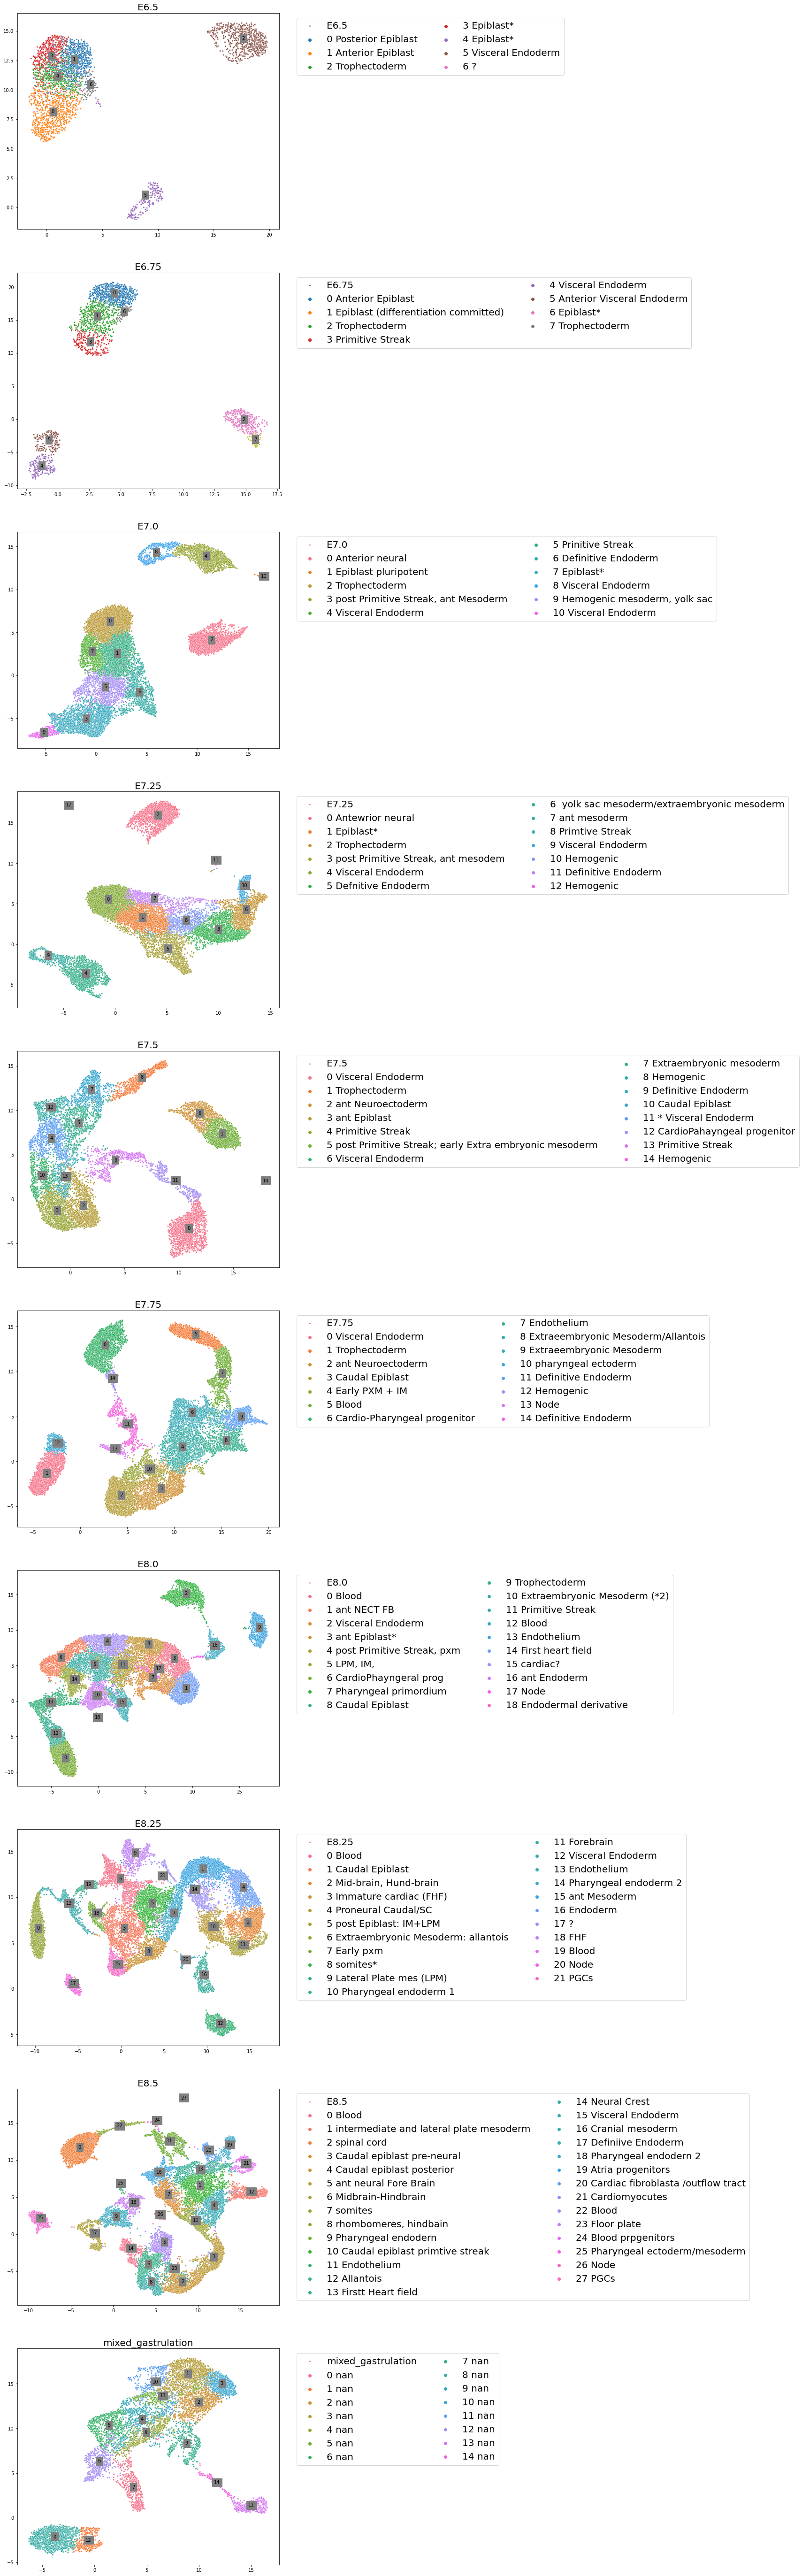

In [13]:
ann = pd.read_excel("./Annotations/Annotations AMA.xlsx",sheet_name=None)

fig1,ax1 = plt.subplots(10,1,figsize=[10,100])

a.obs["Manual_Annotation"] = ""

for j,stage in enumerate(["E6.5","E6.75","E7.0","E7.25","E7.5","E7.75","E8.0","E8.25","E8.5","mixed_gastrulation"]):
    
    posx = j//1
    posy = j%2
    
    b = a[a.obs["stage"]==stage]
    b.obs["sample"]=b.obs["sample"].astype(str)
    
    #Load data from batch correction    
    b.obsm["X_pca"] = np.load("data/PCA_"+stage+".npy")
    b.obsm["X_pca_harmony"] = np.load("data/PCA_harmony_"+stage+".npy")
    b.obsm["X_umap"] = np.load("data/UMAP_harmony_"+stage+".npy")
    
    #Make scatterplots
    sb.scatterplot(b.obsm["X_umap"][:,0],b.obsm["X_umap"][:,1],hue=b.obs["Old_clusters"].astype(str),s=10,ax=ax1[posx])
    ax1[posx].set_title(stage,fontsize=20)
    for k in b.obs["Old_clusters"].unique():
        if k != -1:
            pos = b[b.obs["Old_clusters"]==k,:].obsm["X_umap"]
            pos = np.nan_to_num(pos)
            pos = pos.mean(axis=0)
            kk = k#int(k.split("_")[-1])
            n = ann[stage].loc[kk,"Cluster"]
            if type(n) != str:
                n = str(ann[stage].loc[kk,"Cluster"])
            ax1[posx].text(pos[0]-len(n)*0.1,pos[1],n,fontsize=10,backgroundcolor="grey")

            a.obs.loc[b.obs[b.obs["Old_clusters"]==k].index,"Manual_Annotation"] = ann[stage].loc[kk,"Name"]
        
    ax1[posx].legend([stage,]+[str(i)+" "+str(j) for i,j in zip(ann[stage].loc[:,"Cluster"],ann[stage].loc[:,"Name"])],
                    bbox_to_anchor=(1.05, 1),
                    fontsize=20,
                    ncol=2)
    
a.write("data/qc.h5ad")
fig1.savefig("./Plots/5_Clustering/Louvain_clusters_annotated.png",bbox_inches="tight",transparent=True)
#plt.close(fig1)

# Comparing Manual annotations with previous annotations from Pijuan-Sala

In [ ]:
ann = pd.read_excel("./Annotations/Annotations AMA.xlsx",sheet_name=None)

fig1,ax1 = plt.subplots(10,1,figsize=[10,100])

for j,stage in enumerate(["E6.5","E6.75","E7.0","E7.25","E7.5","E7.75","E8.0","E8.25","E8.5","mixed_gastrulation"]):
    
    posx = j//1
    posy = j%2
    
    b = a[a.obs["stage"]==stage]
    b.obs["sample"]=b.obs["sample"].astype(str)
    
    #Make cluster plots
    for k in b.obs["Clusters_By_Stages"].unique():
        kk = int(k.split("_")[-1])
        n = ann[stage].loc[kk,"Name"]
        if type(n) != str:
            n = str(ann[stage].loc[kk,"Cluster"])
        b.obs.loc[b.obs["Clusters_By_Stages"]==k,"Manual_Annotation"] = n
        a.obs.loc[b[b.obs["Clusters_By_Stages"]==k,:].obs.index.values.astype(str),"Manual_Annotation"] = n
    
    s = b.obs.groupby(["celltype","Manual_Annotation"]).size().unstack()
    s = (s/s.sum(axis=0)).round(2)

    sb.clustermap(s,annot=True)
    plt.savefig("./Plots/5_Clustering/Overlap_"+stage+".png")
    plt.close()

    #Make UMAPS
    hue = b.obs["celltype"]
    keep = False*np.ones_like(hue).astype(bool)
    for j in b.obs["celltype"].unique():
        l = (b.obs["celltype"] == j)
        if np.sum(l)/len(l) > 0.02: #Plot only clusters that are relevant in the process
            None
        else:
            hue.replace(j,"other",inplace=True)
                
    pos = np.argsort(hue)
    b.obsm["X_umap"] = np.load("data/UMAP_harmony_"+stage+".npy")
    X = b.obsm["X_umap"]

    sb.scatterplot(X[pos,0],X[pos,1],hue=hue[pos],s=10,ax=ax1[posx])
    ax1[posx].set_title(stage,fontsize=40)
    ax1[posx].legend(bbox_to_anchor=(1.05, 1))
    
    for l,k in enumerate([ll.get_text() for ll in ax1[posx].legend_.texts]):
        pos = b[hue==k,:].obsm["X_umap"]
        pos = np.nan_to_num(pos)
        pos = pos.mean(axis=0)
        ax1[posx].text(pos[0],pos[1],l,fontsize=20,backgroundcolor="grey")
        ax1[posx].legend_.texts[l].set_text(str(l)+" "+k)
    
fig1.savefig("./Plots/5_Clustering/Pijuan_Annotations.png",bbox_inches="tight",transparent=False)
plt.close(fig1)